# PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle

## 0. Описание кейса и постановка задачи

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, *которая предсказывает рейтинг отеля*. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Вы будете работать с датасетом, в котором содержатся сведения о 515 000 отзывов на отели Европы. Модель, которую вы будете обучать, должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных. Изученные нами навыки разведывательного анализа помогут улучшить модель.

Первоначальная версия датасета содержит 17 полей со следующей информацией:

- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве.
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.

## 1. Подготовка к работе

### 1.1. Импорт библиотек

In [1]:
import os
import pandas as pd
import numpy as np

# Загружаем специальный инструмент для разбивки данных:  
from sklearn.model_selection import train_test_split

# Импортируем необходимые библиотеки:
# для шкалирования
from sklearn import preprocessing
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
# инструменты для оценки точности модели
from sklearn import metrics

# библиотека для логирования эксперимента
from comet_ml import Experiment

# Библиотеки визуализации
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Установка параметров визуализации
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
sns.set_theme(style='darkgrid')

# Собственный модуль обработки данных
from eda import *

# Импорт переменных окружения
from decouple import config

# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

### 1.2. Эксперимент и константы

**Запуск эксперимента**

In [2]:
# Нужно ли логирование в Comet
save_experiment = True # config('SAVE_EXPERIMENT', default=False, cast=bool)

if save_experiment:
    experiment = Experiment(
        api_key=config('COMET_API',default=''),
        project_name='booking-reviews',
        workspace='mvulf'
    )

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mvulf/booking-reviews/4bf6a314b881445cb555ed29fba11851



**Константы обучения**

In [3]:
TEST_SIZE = 0.25
RANDOM_STATE = 42
N_ESTIMATORS = 100
TARGET_NAME = 'reviewer_score'

if 'experiment' in locals():
    # Логируем применяемые параметры
    params = {
        'test_size': TEST_SIZE,
        'random_state': RANDOM_STATE,
        'n_estimators': N_ESTIMATORS,
        'target_name': TARGET_NAME
    }
    experiment.log_parameters(params)

### 1.3. Загрузка данных

In [4]:
# Загрузим данные для обучения
df_train_test = pd.read_csv('input/hotels_train.csv')
display(df_train_test.info())
df_train_test.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [5]:
# Загрузим тестовые данные
df_predict = pd.read_csv('input/hotels_test.csv')
display(df_predict.info())
df_predict.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

None

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [6]:
# Загрузим файл для отправки на оценку
sample_submission = pd.read_csv('input/submission.csv')
display(sample_submission.info())
sample_submission.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


None

,reviewer_score,id
0,1,488440
1,10,274649


### 1.4. Объединение train_test и predict

Объединение необходимо для совместной обработки двух датасетов

In [7]:
df_train_test['sample'] = 1 # пометили данные для train и test
df_predict['sample'] = 0 # пометили данные для финального предсказания predict
# в тесте у нас нет значения reviewer_score, мы его должны предсказать, 
# поэтому пока просто заполняем нулями
df_predict['reviewer_score'] = 0

# Объединяем датасеты для работы
# первым идёт df_test, чтобы индексация совпала с submition
data = pd.concat([df_predict, df_train_test]).reset_index(drop=True)

## 2. Предварительный анализ и подготовка данных

Включает в себя:
- **Предварительный анализ данных (data understanding)** с составлением 
рекомендаций для подготовки данных;
- **Подготовку и очистку данных (data preparation & cleaning)**.
Очистка данных представляет собой:
    - удаление/разметка дубликатов
    - заполнение пропусков
    - удаление/разметка выбросов и аномалий;
- **Создание новых признаков (feature generating)**. 
Часть проектирования признаков (feature engineering, раздел 3). 
Реализуется дополнением внешними данными и комбинацией признаков. 

Последние два пункта частично объединены в этом проекте,
так как создаваемые признаки позволят заполнить пропуски. 


### Предварительный анализ данных (data understanding) 

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Посмотрим на количество уникальных значений

In [9]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

**Note**: 
- Явные пропуски содержатся в колонках долготы и широты местоположения 
отеля (lat & lng).
- В числовом формате данные хранятся в 9 из 16 столбцах. 
Необходимо рассмотреть возможность извлечения полезных признаков.
- Для категориальных признаков будем вводить 'other' для редких значений 
с целью сокращения количества уникальных значений


Более подробный анализ признаков проводится далее

### Подготовка и очистка данных, создание новых признаков (data preparation & cleaning, feature generating)

#### **hotel_address**->*hotel_country & hotel_city* и **hotel_name**(*edit*)

Оценим количество отелей в данных

In [10]:
print(f"Количество уникальных адресов отелей: {data['hotel_address'].nunique()}")
print(f"Количество уникальных имён отелей: {data['hotel_name'].nunique()}")

Количество уникальных адресов отелей: 1493
Количество уникальных имён отелей: 1492


Похоже, что на одно название отеля приходится 2 адреса. Определим, что это за отель.

In [11]:
# Сгруппируем по именам отелей и определим уникальные адреса
hotels_addresses = data.groupby(by='hotel_name')['hotel_address'].nunique()
# Проанализируем количество уникальных адресов для каждого отеля
n_hotels_addresses = hotels_addresses.sort_values(ascending=False)
n_hotels_addresses

hotel_name
Hotel Regina                                    3
11 Cadogan Gardens                              1
Mercure Paris Gare Montparnasse                 1
Mercure Paris Pigalle Sacre Coeur               1
Mercure Paris Opera Louvre                      1
                                               ..
Ham Yard Hotel                                  1
Hallmark Hotel London Chigwell Prince Regent    1
HCC St Moritz                                   1
HCC Regente                                     1
pentahotel Vienna                               1
Name: hotel_address, Length: 1492, dtype: int64

Таким образом, мы видим, что только у "Hotel Regina" имеется несколько уникальных адресов. Посмотрим на эти адреса

In [12]:
# Извлечём название отеля с несколькими адресами
frequent_hotel = n_hotels_addresses.index[0]

# Проанализируем адреса этого отеля
frequent_hotel_addresses = list(data[data['hotel_name'] == frequent_hotel]\
    ['hotel_address'].unique())
print(f'Адреса отеля {frequent_hotel}: {frequent_hotel_addresses}')

Адреса отеля Hotel Regina: ['Bergara 2 4 Eixample 08002 Barcelona Spain', 'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria', 'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy']


У "Hotel Regina" есть 3 адреса в различных странах: Испания, Италия и Австрия.

При этом число уникальных названий отелей и уникальных адресов отличается только на 1 в пользу адреса. Можно предположить, что есть дублирование адреса. Проверим.

In [13]:
# Сгруппируем по адресам отелей и определим уникальные имена
hotels_names = data.groupby(by='hotel_address')['hotel_name'].nunique()
# Проанализируем количество уникальных имён для каждого адреса
n_hotels_names = hotels_names.sort_values(ascending=False)
n_hotels_names.head(5)

hotel_address
8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom    2
Hernalser Hauptstra e 105 17 Hernals 1170 Vienna Austria                      1
Hoffingergasse 26 28 12 Meidling 1120 Vienna Austria                          1
Hobbemakade 50 Oud Zuid 1071 XL Amsterdam Netherlands                         1
Hintschiggasse 1 10 Favoriten 1100 Vienna Austria                             1
Name: hotel_name, dtype: int64

Таким образом, есть адрес, по которому зарегистрировано 2 отеля. Посмотрим на названия отелей.

In [14]:
# Извлечём адрес с несколькими отелями
frequent_address = n_hotels_names.index[0]

# Проанализируем отели одного адреса
frequent_address_hotels = list(data[data['hotel_address'] ==\
    frequent_address]['hotel_name'].unique())
print(f'Названия отелей по адресу {frequent_address}: {frequent_address_hotels}')

Названия отелей по адресу 8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom: ['Club Quarters Hotel Trafalgar Square', 'The Grand at Trafalgar Square']


Проверка с помощью онлайн-карт google подтвердила, что по одному адресу зарегистрированы 2 отеля.

Посмотрим на частоту отзывов отелей:

In [15]:
display(data.groupby(by=['hotel_name','hotel_address'])['review_date']\
    .count().sort_values(ascending=True).reset_index().head(1200))
display(data.groupby(by=['hotel_name','hotel_address'])['review_date']\
    .count().sort_values(ascending=False).reset_index().head(300))

,hotel_name,hotel_address,review_date
0,Hotel Gallitzinberg,Johann Staud Stra e 32 16 Ottakring 1160 Vienn...,8
1,Mercure Paris Porte d Orleans,13 Rue Fran ois Ory 92120 Paris France,10
2,Hotel Wagner,Via M Buonarroti 13 Fiera Milano City 20149 Mi...,10
3,Ibis Styles Milano Palmanova,Via Palmanova 153 20132 Milan Italy,12
4,Le Lavoisier,21 rue Lavoisier 8th arr 75008 Paris France,12
...,...,...,...
1195,Hotel Prinz Eugen,Wiedner G rtel 14 04 Wieden 1040 Vienna Austria,511
1196,Hotel Mozart,Piazza Gerusalemme 6 Sempione 20154 Milan Italy,512
1197,Worldhotel Cristoforo Colombo,Corso Buenos Aires 3 Milan City Center 20124 M...,512
1198,H10 Metropolitan 4 Sup,Rambla Catalunya 7 9 Eixample 08007 Barcelona ...,514


,hotel_name,hotel_address,review_date
0,Britannia International Hotel Canary Wharf,163 Marsh Wall Docklands Tower Hamlets London ...,4789
1,Strand Palace Hotel,372 Strand Westminster Borough London WC2R 0JJ...,4256
2,Park Plaza Westminster Bridge London,Westminster Bridge Road Lambeth London SE1 7UT...,4169
3,Copthorne Tara Hotel London Kensington,Scarsdale Place Kensington Kensington and Chel...,3578
4,DoubleTree by Hilton Hotel London Tower of London,7 Pepys Street City of London London EC3N 4AF ...,3212
...,...,...,...
295,H10 Metropolitan 4 Sup,Rambla Catalunya 7 9 Eixample 08007 Barcelona ...,514
296,Hotel Mozart,Piazza Gerusalemme 6 Sempione 20154 Milan Italy,512
297,Worldhotel Cristoforo Colombo,Corso Buenos Aires 3 Milan City Center 20124 M...,512
298,Hotel Capricorno,Schwedenplatz 3 4 01 Innere Stadt 1010 Vienna ...,511


In [16]:
predict_names = set(df_predict['hotel_name'].unique())
train_test_names = set(df_train_test['hotel_name'].unique())

if train_test_names == predict_names:
    print('И обучающая, и предсказательная выборки имён отелей одинаковы')

И обучающая, и предсказательная выборки имён отелей одинаковы


**Note**:
- При генерации признаков из полного адреса можно извлечь город и страну расположения отеля.
- К имени 'Hotel Regina' можно добавить страну расположения отеля.
- В обоих исходных датасетах представлены одни и те же отели
- Нужен ли нам для обучения такой признак, как имя отеля?

Если нужен, то в дальнейшем может потребоваться уменьшить количество уникальных названий отеля, введя категорию other_name для остальных названий. *Например, при сокращении до 300 уникальных имён отелей по количеству отзывов.* Тем не менее, данный признак очень похож на неинформативный из-за слишком большого количества уникальных имён.
- Скорее всего, признак имени стоит исключить из обучения как по причине неинформативности, так и с точки зрения конечной цели создания модели - необходимо предотвращать накрутку рейтингов нечестными отелями. Проверка будет осуществляться самых разных отелей, различной популярности, в том числе и малопопулярных. Название само по себе малополезно, так как у нас уже есть сведения об общем количестве оставленных отзывов каждому из отелей.
- Можно оценить влияние количества слов в названии на медианную оценку - есть ли оно?

**Извлечём страну и город каждого из отелей**

In [17]:
print('Посмотрим на последнее слово в адресе, '+\
    'которое должно представлять собой страну:')
data['hotel_address'].apply(lambda x: x.split()[-1]).unique()

Посмотрим на последнее слово в адресе, которое должно представлять собой страну:


array(['Italy', 'Netherlands', 'Spain', 'Kingdom', 'France', 'Austria'],
      dtype=object)

Видим, что Страны однословные, за исключением Великобритании. Учтём это.

In [18]:
# Учтём двусловность United Kingdom
data['hotel_country'] = data['hotel_address'].apply(lambda x:\
    x.split()[-1] if x.split()[-1] != 'Kingdom' else ' '.join(x.split()[-2:]))
print('Представленные в датасете страны:')
print(data['hotel_country'].unique())

Представленные в датасете страны:
['Italy' 'Netherlands' 'Spain' 'United Kingdom' 'France' 'Austria']


Посмотрим на города отелей из Великобритании

In [19]:
data[data['hotel_country'] == 'United Kingdom']['hotel_address'].unique()

array(['Coram Street Camden London WC1N 1HT United Kingdom',
       'Empire Way Wembley Brent London HA9 8DS United Kingdom',
       '1 Shortlands Hammersmith and Fulham London W6 8DR United Kingdom',
       '49 Gloucester Place Marble Arch Westminster Borough London W1U 8JE United Kingdom',
       '101 Buckingham Palace Road Westminster Borough London SW1W 0SJ United Kingdom',
       '30 Portman Square Westminster Borough London W1H 7BH United Kingdom',
       '81 103 Euston Street Camden London NW1 2EZ United Kingdom',
       '34 Lombard Road Battersea London SW11 3RF United Kingdom',
       '30 Jamestown Road Camden London NW1 7BY United Kingdom',
       '52 Chiswell Street City of London London EC1Y 4SD United Kingdom',
       'Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom',
       '130 135 Minories City of London London EC3N 1NU United Kingdom',
       '4 18 Harrington Gardens Kensington and Chelsea London SW7 4LH United Kingdom',
       '6 Frith S

В случае с Великобританией видим, что город в адресе отделён от страны почтовым индексом, причём представлен только Лондон. Учтём это при извлечении города

In [20]:
# Retrieve hotel city (consider United Kingdom)
data['hotel_city'] = data.apply(lambda x: x['hotel_address'].split()[-5] 
    if x['hotel_country'] == 'United Kingdom' else x['hotel_address']\
        .split()[-2], axis=1)
print(data['hotel_city'].unique())

['Milan' 'Amsterdam' 'Barcelona' 'London' 'Paris' 'Vienna']


**Определим количество слов в названии отеля**

Проверим, есть ли влияние на целевую функцию

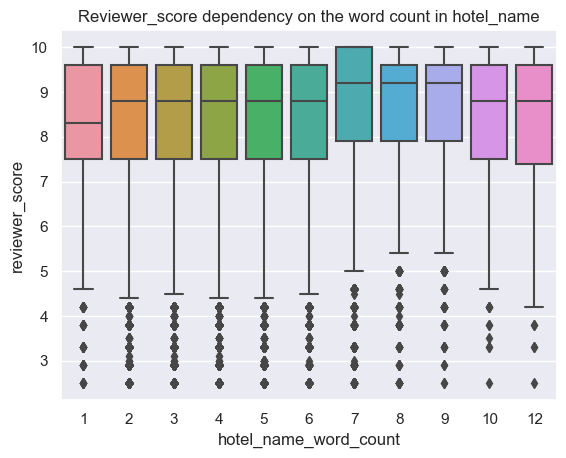

In [21]:
# Создадим признак с количеством слов в имени
data['hotel_name_word_count'] = data['hotel_name']\
    .apply(lambda x: len(x.split(' ')))

sns.boxplot(x='hotel_name_word_count', y = 'reviewer_score', 
    data=data.query('sample==1'))
plt.title('Reviewer_score dependency on the word count in hotel_name');

count    515738.000000
mean          3.933974
std           1.428819
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max          12.000000
Name: hotel_name_word_count, dtype: float64

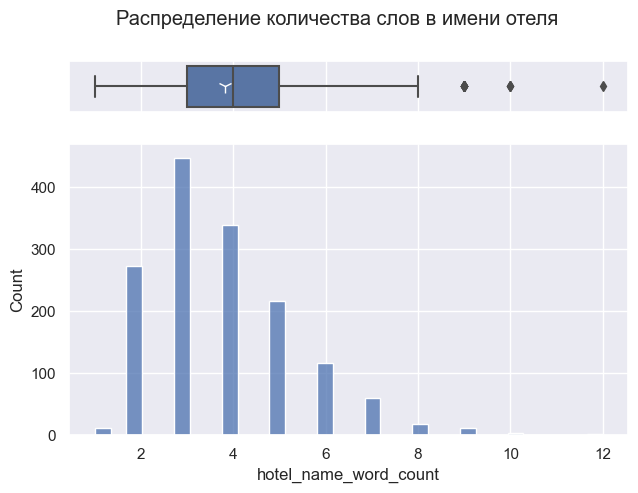

In [22]:
display(data['hotel_name_word_count'].describe())

hotel_name_word_count = data.groupby(by=['hotel_name', 'hotel_address'])\
    ['hotel_name_word_count'].median().reset_index()
box_hist_plot(hotel_name_word_count, 'hotel_name_word_count',\
    'Распределение количества слов в имени отеля')

При необходимости, можно было бы в дальнейшем 
проверить статистическую значимость результата, что отели с размером имён в 
7-9 слов имеют несколько выше медианный рейтинг, 
поэтому пока оставим этот показатель

**Дополним имя отеля Hotel Regina городом**

Сделано для удобства последующего предварительного анализа колонок

In [23]:
data['hotel_name'] = data.apply(lambda x: x['hotel_name']+ ' [' +\
    x['hotel_city'] + ']' if x['hotel_name']=='Hotel Regina'\
    else x['hotel_name'], axis=1)

data[data['hotel_name'].str.contains('Hotel Regina')]['hotel_name'].unique()

array(['Hotel Regina [Barcelona]', 'Hotel Regina [Vienna]',
       'Hotel Regina [Milan]'], dtype=object)

#### **additional_number_of_scoring**

Согласно представленному выше описанию получается, что это общее количество оценок без отзывов, которое выставлено отелю. Значит у разных отзывов одного отеля должны быть одинаковые значения. Проверим это.

count    515738.000000
mean        498.081836
std         500.538467
min           1.000000
25%         169.000000
50%         341.000000
75%         660.000000
max        2682.000000
Name: additional_number_of_scoring, dtype: float64

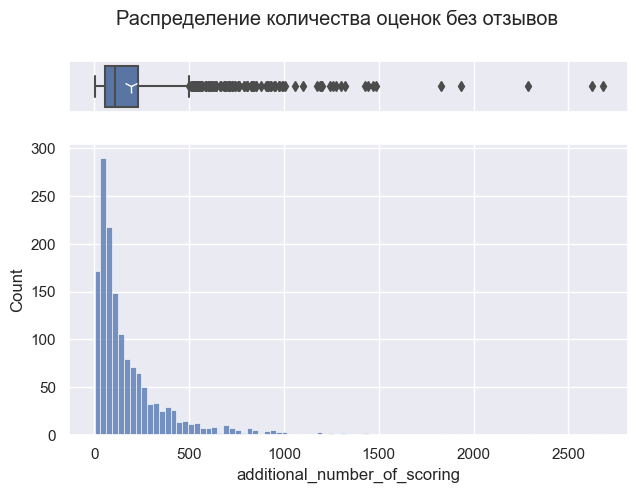

In [24]:
display(data['additional_number_of_scoring'].describe())

addit_n_scoring = data.groupby(by=['hotel_name', 'hotel_address'])\
    ['additional_number_of_scoring'].median().reset_index()
box_hist_plot(addit_n_scoring, 'additional_number_of_scoring',\
    'Распределение количества оценок без отзывов')

In [25]:
grouped_by_name = data.groupby(by='hotel_name')
scoring_number_difference = grouped_by_name['additional_number_of_scoring']\
    .max() - grouped_by_name['additional_number_of_scoring'].min()
scoring_number_difference.sort_values(ascending=False)

hotel_name
11 Cadogan Gardens                              0
Mercure Paris Gare De Lyon TGV                  0
Mercure Paris Opera Louvre                      0
Mercure Paris Opera Grands Boulevards           0
Mercure Paris Opera Garnier                     0
                                               ..
Hampshire Hotel Amsterdam American              0
Ham Yard Hotel                                  0
Hallmark Hotel London Chigwell Prince Regent    0
HCC St Moritz                                   0
pentahotel Vienna                               0
Name: additional_number_of_scoring, Length: 1494, dtype: int64

Видим, что разницы в количестве отзывов нет, 
все имена отелей уникальны и содержат одно и тоже количество отзывов

**Note:**
- Распределение похоже на логнормальное. 
Стоит прологарифмировать и проверить на нормальность

Прологарифмируем признак

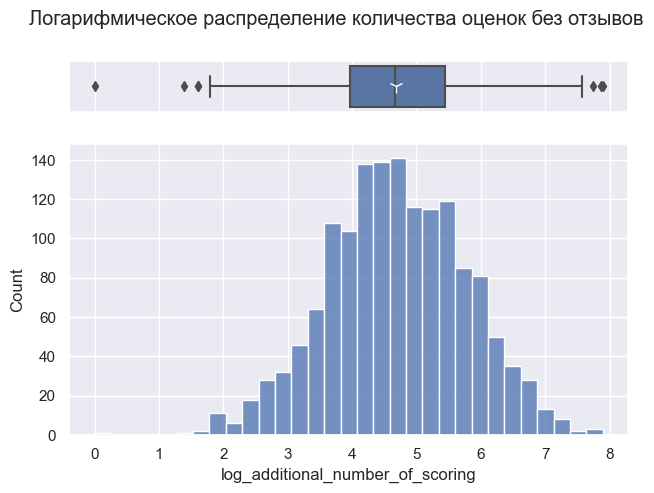

In [26]:
data['log_additional_number_of_scoring'] =\
    np.log(data['additional_number_of_scoring'])

log_addit_n_scoring = data.groupby(by=['hotel_name'])\
    ['log_additional_number_of_scoring'].median().reset_index()
box_hist_plot(log_addit_n_scoring, 'log_additional_number_of_scoring',\
    'Логарифмическое распределение количества оценок без отзывов')

#### **review_date**->datetime->month & season -> winter_review

Приведём к формату datetime

In [27]:
data['review_date'] = pd.to_datetime(data['review_date'])
data['review_date'].describe(datetime_is_numeric=True)

count                           515738
mean     2016-08-13 13:23:37.096277248
min                2015-08-04 00:00:00
25%                2016-02-23 00:00:00
50%                2016-08-15 00:00:00
75%                2017-02-09 00:00:00
max                2017-08-03 00:00:00
Name: review_date, dtype: object

Таким образом, перед нами выгрузка отзывов за 2 года с 4 августа 2015 года по 3 августа 2017 года.

**Note:**
- В дальнейшем из даты можно извлечь сезонность

**Извлечём из даты сезонность**

In [28]:
def get_season(month):
    if month in [3,4,5]:
        return 'spring'
    if month in [6,7,8]:
        return 'summer'
    if month in [9,10,11]:
        return 'autumn'
    if month in [12,1,2]:
        return 'winter'
    
data['review_month'] = data['review_date'].dt.month
data['review_season'] = data['review_month'].apply(get_season)
data['review_season'].value_counts()

summer    142886
spring    130483
autumn    122241
winter    120128
Name: review_season, dtype: int64

count    515738.000000
mean          6.486660
std           3.351779
min           1.000000
25%           4.000000
50%           7.000000
75%           9.000000
max          12.000000
Name: review_month, dtype: float64

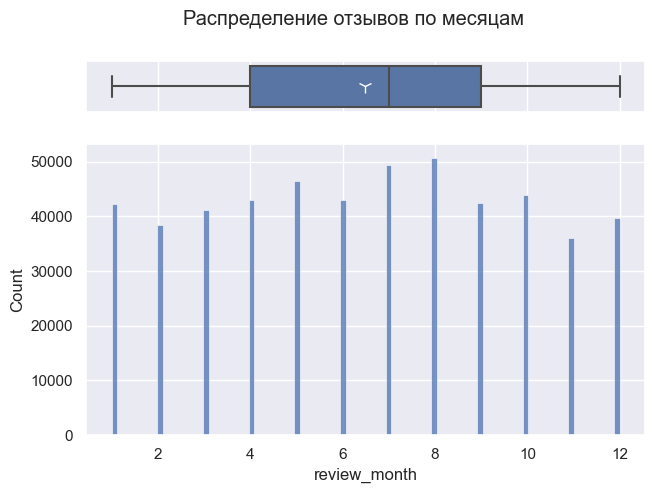

In [29]:
display(data['review_month'].describe())

box_hist_plot(data, 'review_month',\
    'Распределение отзывов по месяцам')

Оценим наличие влияния месяца и сезонности на отзыв

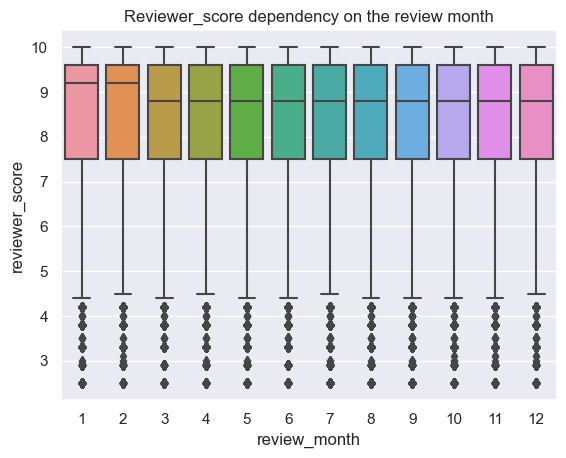

In [30]:
sns.boxplot(x='review_month', y = 'reviewer_score', 
    data=data.query('sample==1'))
plt.title('Reviewer_score dependency on the review month');

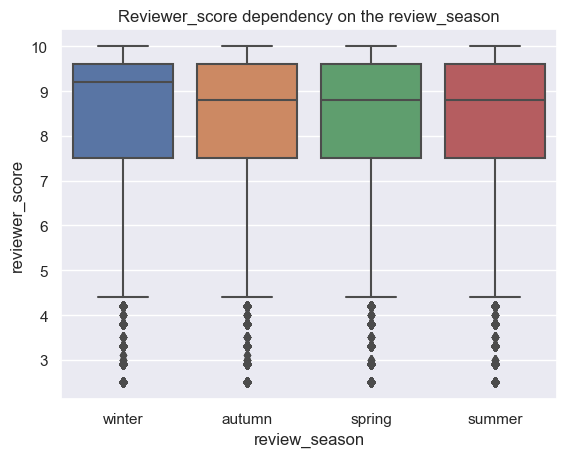

In [31]:
sns.boxplot(x='review_season', y = 'reviewer_score', 
    data=data.query('sample==1'))
plt.title('Reviewer_score dependency on the review_season');

Имеется небольшое расхождение по месяцам и сезонам: медианный рейтинг зимой 
(Январь-Февраль) выше, чем в остальные месяцы. Введём бинарный рейтинг

In [32]:
data['winter_review'] = data['review_month'].apply(lambda x: 1 if x in [1,2]
                                                   else 0)

#### **average_score**

Данный признак представляет собой среднюю оценку отеля за последний год. Проанализируем его

count    515738.000000
mean          8.397487
std           0.548048
min           5.200000
25%           8.100000
50%           8.400000
75%           8.800000
max           9.800000
Name: average_score, dtype: float64

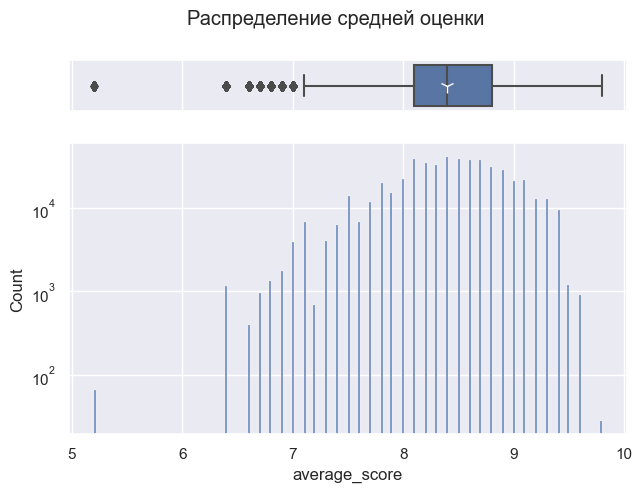

In [33]:
average_score_plot = box_hist_plot(data, 'average_score',\
    'Распределение средней оценки', hist_yscale='log')
display(data['average_score'].describe())
average_score_plot

Наблюдаем левосторонние гипотетические выбросы, а также отели с очень высокой оценкой

Введём группировку по отелям

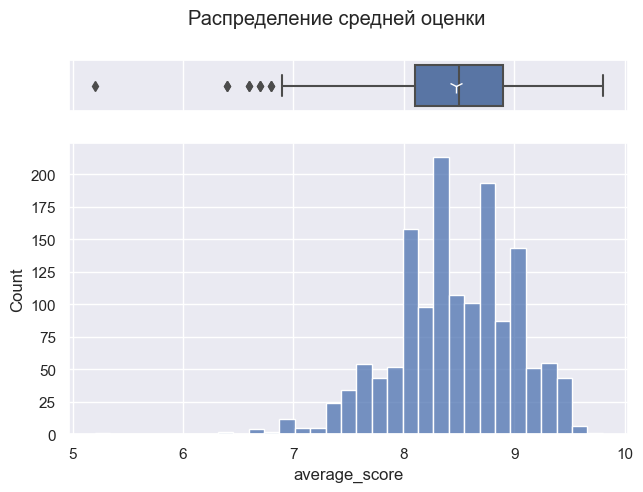

In [34]:
average_score = data.groupby(by=['hotel_name'])\
    ['average_score'].median().reset_index()
box_hist_plot(average_score, 'average_score',\
    'Распределение средней оценки')

**Note**:
- Имеет смысл ввести порядковый категориальный признак, чтобы отличать плохие, хорошие и очень хорошие отели
- Стоит проверить на нормальность

Воспользуемся [шкалой оценок отелей](https://krass56-ru.turbopages.org/krass56.ru/s/scale_of_rating_of_hotel_which_rating_of_hotel_to_choose_for_staying.html)

In [35]:
normal_rating = 7.0
good_rating = 8.0
excelent_rating = 9.0

def get_score_rating(average_score):
    # not good
    if average_score < normal_rating:
        return 0
    # normal
    if average_score >= normal_rating and average_score < good_rating:
        return 1
    # good
    if average_score >= good_rating and average_score < excelent_rating:
        return 2
    # excellent
    if average_score >= excelent_rating:
        return 3
    
data['hotel_rating'] = data['average_score'].apply(get_score_rating)
data['hotel_rating'].value_counts()

2    341578
1     88982
3     79513
0      5665
Name: hotel_rating, dtype: int64

Оценим визуально взаимосвязь средней оценки и медианной оценки в отзыве

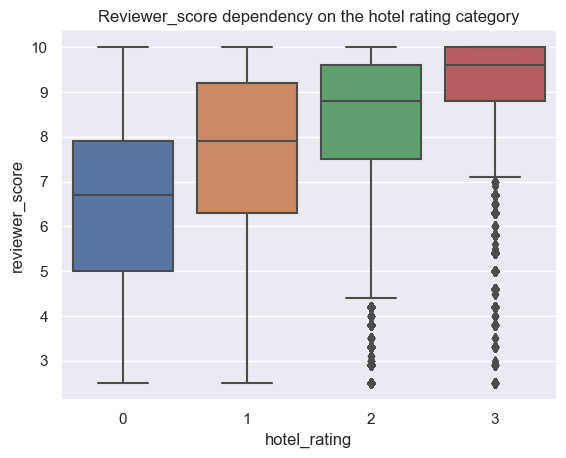

In [36]:
sns.boxplot(x='hotel_rating', y = 'reviewer_score', 
    data=data.query('sample==1'))
plt.title('Reviewer_score dependency on the hotel rating category');

**Note**: имеется заметная взаимосвязь с рейтингом отеля, что ожидаемо

#### **reviewer_nationality** -> TODO!

In [37]:
print('Представленные в датасете национальности:')
display(data['reviewer_nationality'].value_counts())

Представленные в датасете национальности:


 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Comoros                           1
 Anguilla                          1
 Tuvalu                            1
 Cape Verde                        1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64

**Note**:
- Возможно, имеет смысл сопоставить национальность рецензента и страну, где находится отель. И выделить признак международного путешествия рецензента. 
- Можно проверить гипотезу влияния типа поездки - международная или национальная на оставляемый рейтинг.
- Также можно уменьшить количество рассматриваемых национальностей, введя категорию 'other'
- Скрытые пропуски не обнаружены

#### **tags** -> **splitted_tags** -> TODO!

Извлечём теги и сохраним их в множество, тем самым получим уникальные теги.

In [38]:
# Извлечём сырые теги из соответствующей колонки 
# и сохраним в виде списка
data['splitted_tags'] = data['tags'].str.findall(r"'[\w\s]+'")

# Преобразуем списки, удалив одинарные кавычки и внешние пробелы
data['splitted_tags'] = data['splitted_tags'].\
    apply(lambda x: [y[1:-1].strip() for y in x])
    
# Создадим множество уникальных тегов
unique_tags = set()
# Функия извлечения тегов в множество
def get_tags(tags):
    unique_tags.update(tags)
    return True
data['splitted_tags'].apply(get_tags)
print('Количество уникальных тегов:', len(unique_tags))

Количество уникальных тегов: 2428


In [39]:
print('Минимальное количество тегов в отзыве:', data['splitted_tags']\
    .apply(len).min())

Минимальное количество тегов в отзыве: 1


Пропуски тегов отсутствуют

Оценим популярность тегов

In [40]:
from collections import Counter

# Создадим пустой список, который будем заполнять тегами 
# из датафрейма 
tags_list = []
def extend_tags(tags):
    tags_list.extend(tags)
data['splitted_tags'].apply(extend_tags)

# Посчитаем количество применений тегов
# и представим в виде Series
cnt = Counter(tags_list)
tag_cnt = pd.Series(dict(cnt))

# Выведем отсортированный Series
tag_cnt.sort_values(ascending=False).head(28)

Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Stayed 4 nights                    47817
Double Room                        35207
Standard Double Room               32248
Superior Double Room               31393
Family with older children         26349
Deluxe Double Room                 24823
Double or Twin Room                22393
Stayed 5 nights                    20845
Standard Double or Twin Room       17483
Classic Double Room                16989
Superior Double or Twin Room       13570
2 rooms                            12393
Stayed 6 nights                     9776
Standard Twin Room                  9745
Single Room     

**Note**:
- В качестве отдельного признака можно создать количество присвоенных тегов
- Имеет смысл выделить конкретные популярные теги
- Из тегов можно выделить такую полезную информацию, как:
    - отправлен ли отзыв с мобильного устройства;
    - количество ночей, проведённых в гостинице;
    - тип номера;
    - тип путешествия;
    - состав посетителей;

#### **negative_review** и **positive_review** -> TODO!

In [41]:
print('Частые негативные отзывы')
data['negative_review'].value_counts().sort_values(ascending=False).head(30)

Частые негативные отзывы


No Negative            127890
 Nothing                14295
 Nothing                 4236
 nothing                 2225
 N A                     1037
 None                     984
                          849
 N a                      509
 Breakfast                407
 Small room               373
 Location                 368
 Everything               326
 All good                 318
 Nothing really           316
 none                     302
 nothing                  283
 No complaints            274
 Price                    260
 Nothing really           254
 Nil                      247
 n a                      227
 Nothing at all           221
 Nothing to dislike       209
 Nothing at all           194
 Small rooms              188
 None                     182
 No complaints            176
 All good                 152
 NA                       148
 Expensive                142
Name: negative_review, dtype: int64

In [42]:
print('Частые позитивные отзывы')
data['positive_review'].value_counts().sort_values(ascending=False).head(30)

Частые позитивные отзывы


No Positive            35946
 Location               9222
 Everything             2284
 location               1677
 Nothing                1243
 The location           1126
 Great location         1047
 Good location           927
 Location                915
 Everything              613
 Breakfast               608
 Friendly staff          515
 Staff                   453
 Excellent location      392
 Great location          372
 Location and staff      333
 everything              319
 Good location           276
 Nothing                 225
 Comfy bed               222
 nothing                 217
 The location            215
 good location           206
 The staff               197
 Good breakfast          189
                         183
 Location staff          180
 the location            180
 Location was great      178
 Location was good       178
Name: positive_review, dtype: int64

**Note**:
- Мы видим, что в отзывах большое количество слов, типа "No Positive/Negative", "Nothing", "Everything", "NA". Их можно представить в виде булевых признаков, типа "no_positive", "no_negative", "abs_positive", "abs_negative"
- Из отзывов можно извлечь, чем клиент был доволен/недоволен, например: "location", "staff" и проверить гипотезу влияния этих категорий на оценку

#### **review_total_negative_word_counts** и **review_total_positive_word_counts** -> TODO!

count    515738.000000
mean         18.539450
std          29.690831
min           0.000000
25%           2.000000
50%           9.000000
75%          23.000000
max         408.000000
Name: review_total_negative_word_counts, dtype: float64

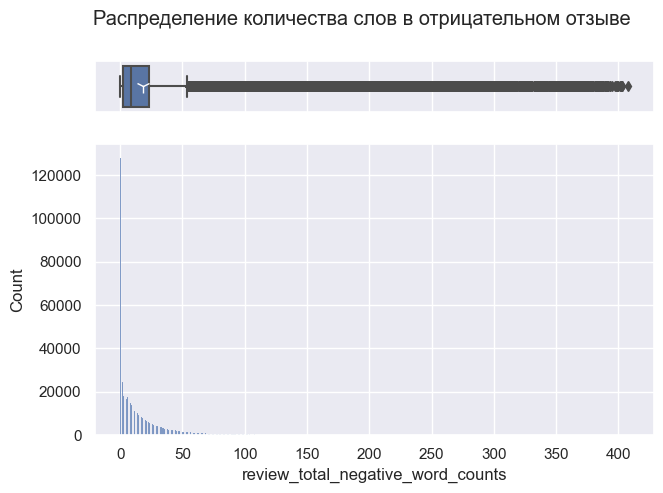

In [43]:
display(data['review_total_negative_word_counts'].describe())
box_hist_plot(data, 'review_total_negative_word_counts',\
    'Распределение количества слов в отрицательном отзыве')

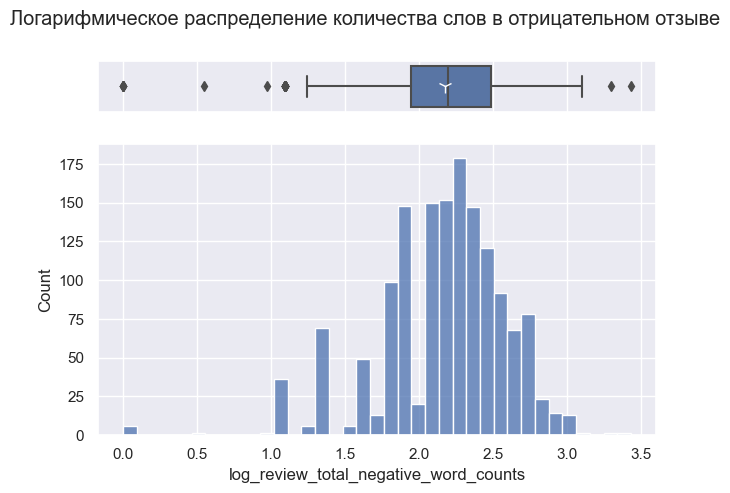

In [44]:
new_column_name = 'log_review_total_negative_word_counts'
data[new_column_name] =\
    np.log(data['review_total_negative_word_counts'] + 1)

log_review_total_negative_word_counts = data.groupby(by=['hotel_name'])\
    [new_column_name].median().reset_index()
box_hist_plot(log_review_total_negative_word_counts,
    new_column_name,
    'Логарифмическое распределение количества слов в отрицательном отзыве')

count    515738.000000
mean         17.776458
std          21.804185
min           0.000000
25%           5.000000
50%          11.000000
75%          22.000000
max         395.000000
Name: review_total_positive_word_counts, dtype: float64

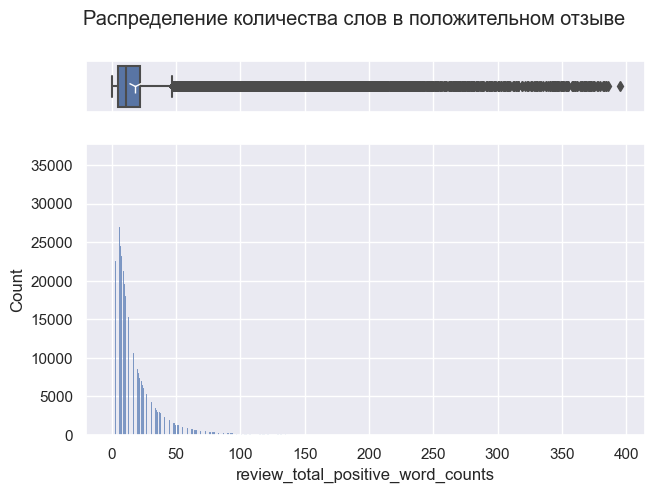

In [45]:
display(data['review_total_positive_word_counts'].describe())
box_hist_plot(data, 'review_total_positive_word_counts',\
    'Распределение количества слов в положительном отзыве')

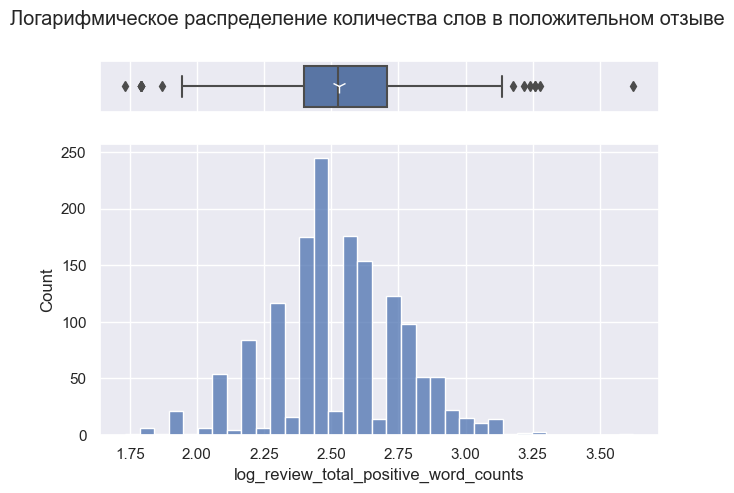

In [46]:
new_column_name = 'log_review_total_positive_word_counts'
data[new_column_name] =\
    np.log(data['review_total_positive_word_counts'] + 1)

log_review_total_positive_word_counts = data.groupby(by=['hotel_name'])\
    [new_column_name].median().reset_index()
box_hist_plot(log_review_total_positive_word_counts,
    new_column_name,
    'Логарифмическое распределение количества слов в положительном отзыве')

**Note:**
- Позитивные и негативные отзывы могут содержать до нескольких сот слов. При этом медианное количество слов порядка 10.
- Необходимо проверить, влияет ли количество слов больше 20 на оценку.
- При отсутствии слов можно отнести к категориям, выделенным выше по отзывам: no_positive, no_negative
- Возможно, имеет смысл ввести категориальный признак: короткий, средний, длинный комментарий
- Распределения похожи на логнормальные. Логарифмирование проведено. Необходимо проверить на нормальность

#### TARGET: **reviewer_score**

count    386803.000000
mean          8.396906
std           1.636090
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: reviewer_score, dtype: float64

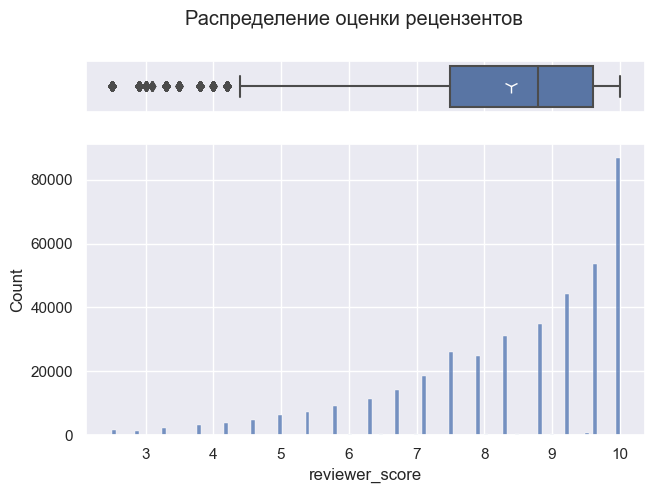

In [47]:
display(data.query('sample==1')['reviewer_score'].describe())
box_hist_plot(data.query('sample==1'), 'reviewer_score', 'Распределение оценки рецензентов')

На данном этапе не будем избавляться от аномальных значений целевого признкака.

#### **total_number_of_reviews_reviewer_has_given** -> drop

count    515738.000000
mean          7.166001
std          11.040228
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max         355.000000
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

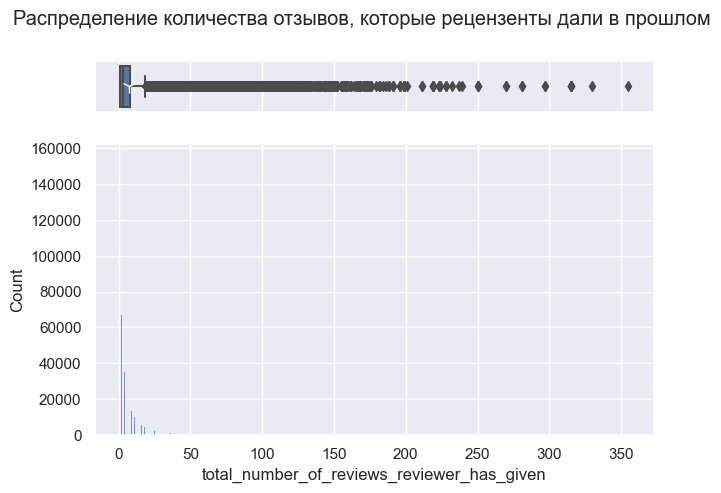

In [48]:
display(data['total_number_of_reviews_reviewer_has_given'].describe())
box_hist_plot(data, 'total_number_of_reviews_reviewer_has_given',\
    'Распределение количества отзывов, которые рецензенты дали в прошлом')

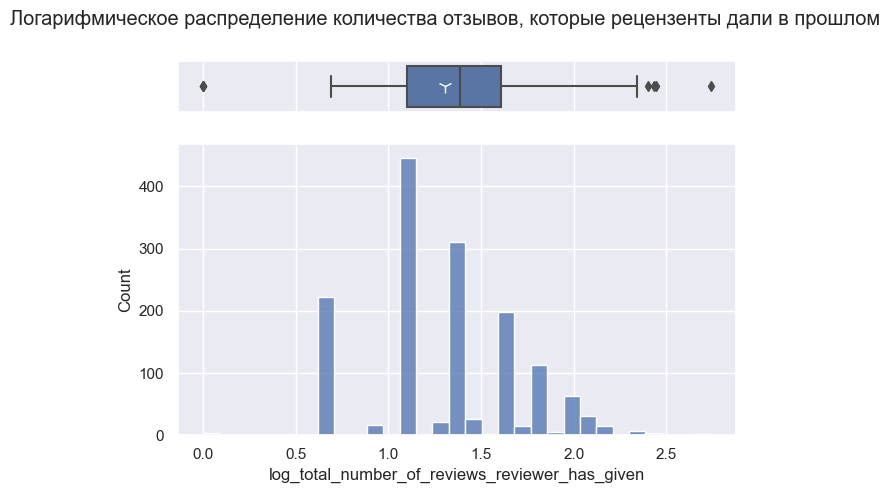

In [49]:
new_column_name = 'log_total_number_of_reviews_reviewer_has_given'
data[new_column_name] =\
    np.log(data['total_number_of_reviews_reviewer_has_given'])

log_total_number_of_reviews_reviewer_has_given = data.groupby(by=['hotel_name'])\
    [new_column_name].median().reset_index()
box_hist_plot(log_total_number_of_reviews_reviewer_has_given,
    new_column_name,
    'Логарифмическое распределение количества отзывов, которые рецензенты дали в прошлом')

**Note:**
- Порядка четверти рецензентов оставляли единственный отзывов, и 3/4 рецензентов оставляли 8 и менее отзывов
- Возможно, имеет смысл ввести порядковый категориальный признак - один, несколько, много отзывов.
- Либо, прологарифмировать и проверить на нормальность.

**Введём порядковый категориальный признак на количество оставленных отзывов**

In [50]:
few_threshold = 5

def get_reviews_class(reviews_count):
    if reviews_count == 1:
        # One review
        return 0
    if reviews_count <= few_threshold:
        # A few reviews
        return 1
    else:
        # many reviews
        return 2

data['reviews_count_class'] = data\
['total_number_of_reviews_reviewer_has_given'].apply(get_reviews_class)
data['reviews_count_class'].value_counts()

2    184521
1    176577
0    154640
Name: reviews_count_class, dtype: int64

Оценим визуально взаимосвязь количества оценок и медианной оценки в отзыве

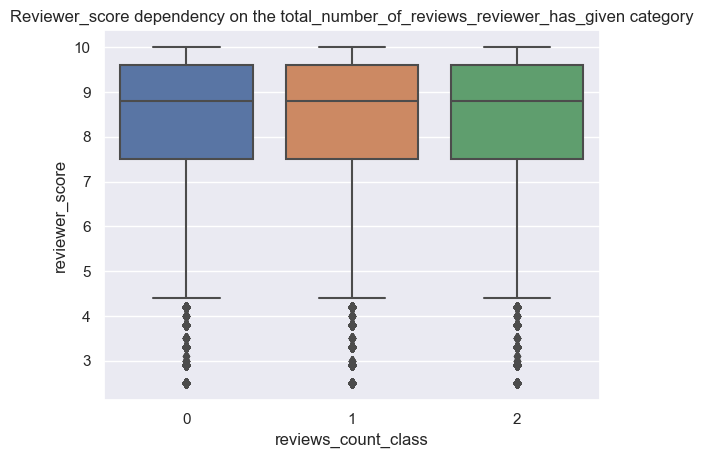

In [51]:
sns.boxplot(x='reviews_count_class', y = 'reviewer_score', 
    data=data.query('sample==1'))
plt.title('Reviewer_score dependency on the total_number_of_reviews_reviewer_has_given category');

**Note:**
- Таким образом, зависимость от количества оставленных отзывов не обнаружена.
Вероятно, можно исключать данный признак и его предшественника.

#### **total_number_of_reviews** & **additional_number_of_scoring**

**additional_number_of_scoring** рассмотрен выше. Здесь рассматривается
в связке с **total_number_of_reviews**

count    515738.000000
mean       2743.743944
std        2317.464868
min          43.000000
25%        1161.000000
50%        2134.000000
75%        3613.000000
max       16670.000000
Name: total_number_of_reviews, dtype: float64

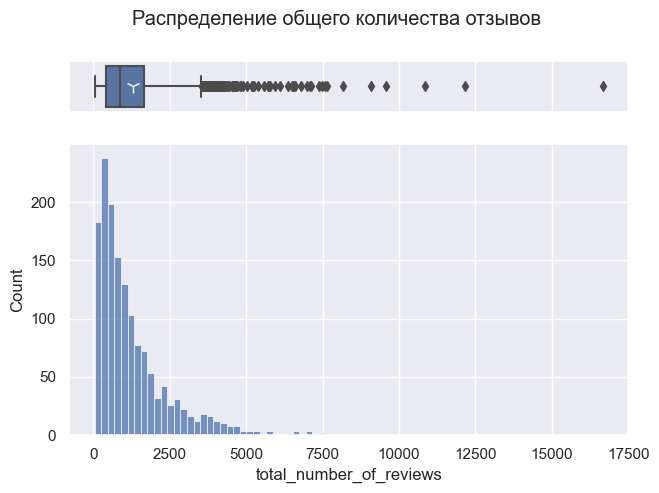

In [52]:
display(data['total_number_of_reviews'].describe())

total_n_reviews = data.groupby(by=['hotel_name', 'hotel_address'])\
    ['total_number_of_reviews'].median().reset_index()
box_hist_plot(total_n_reviews, 'total_number_of_reviews',\
    'Распределение общего количества отзывов')

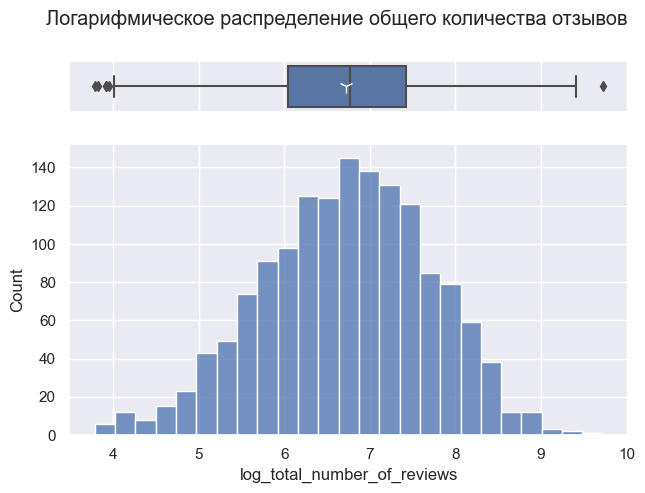

In [53]:
new_column_name = 'log_total_number_of_reviews'
data[new_column_name] =\
    np.log(data['total_number_of_reviews'] + 1)

log_total_number_of_reviews = data.groupby(by=['hotel_name'])\
    [new_column_name].median().reset_index()
box_hist_plot(log_total_number_of_reviews,
    new_column_name,
    'Логарифмическое распределение общего количества отзывов')

Логарифмическое распределение стоит проверить на нормальность

Рассмотрим, как соотносится количество действительных отзывов отеля с количеством отзывов, представленных в датасете. Соотнесём количество отзывов с количеством оценок без отзывов

In [54]:
# Сгруппируем отели и рассмотрим количество отзывов, и количество оценок без
# отзывов
hotels_number_of_reviews = data.groupby(by='hotel_name')\
    .agg({
    'total_number_of_reviews': ['median','count'],
    'additional_number_of_scoring': 'median'
    })
hotels_number_of_reviews.columns = ['_'.join(col) for col\
    in hotels_number_of_reviews.columns]

# Переименуем колонки
hotels_number_of_reviews = hotels_number_of_reviews.rename(columns={
    # Количество отзывов, представленных в датасете
    'total_number_of_reviews_count': 'df_reviews_count', 
    # Количество оценок без отзывов
    'total_number_of_reviews_median': 'total_number_of_reviews',
    'additional_number_of_scoring_median': 'only_marks_count'})

# Выделим процентные характеристики количества отзывов и оценок без отзывов
only_reviews_count = hotels_number_of_reviews['total_number_of_reviews'] -\
        hotels_number_of_reviews['only_marks_count']

hotels_number_of_reviews['df_reviews_percentage_ratio'] =\
    hotels_number_of_reviews['df_reviews_count']\
    /only_reviews_count*100
    
hotels_number_of_reviews['only_reviews_percentage_ratio'] =only_reviews_count\
    /hotels_number_of_reviews['total_number_of_reviews']*100
    
hotels_number_of_reviews['only_marks_percentage_ratio'] =\
    hotels_number_of_reviews['only_marks_count']\
    /hotels_number_of_reviews['total_number_of_reviews']*100
    
print('Процентное соотношение отзывов, представленных в датафрейме, '+\
    'к количеству отзывов с текстом; '+\
    'количества отзывов с текстом к общему количеству отзывов; '
    'а также количества оценок без отзыва к общему количеству отзывов')
display(hotels_number_of_reviews[['df_reviews_percentage_ratio',\
    'only_reviews_percentage_ratio', 'only_marks_percentage_ratio']]\
        .describe())

Процентное соотношение отзывов, представленных в датафрейме, к количеству отзывов с текстом; количества отзывов с текстом к общему количеству отзывов; а также количества оценок без отзыва к общему количеству отзывов


,df_reviews_percentage_ratio,only_reviews_percentage_ratio,only_marks_percentage_ratio
count,1494.000000,1494.000000,1494.000000
mean,32.174593,85.226879,14.773121
std,17.826195,7.244809,7.244809
min,4.819277,60.294118,2.040816
25%,18.930898,80.647076,9.170629
50%,26.484290,87.118865,12.881135
75%,44.132341,90.829371,19.352924
max,89.473684,97.959184,39.705882


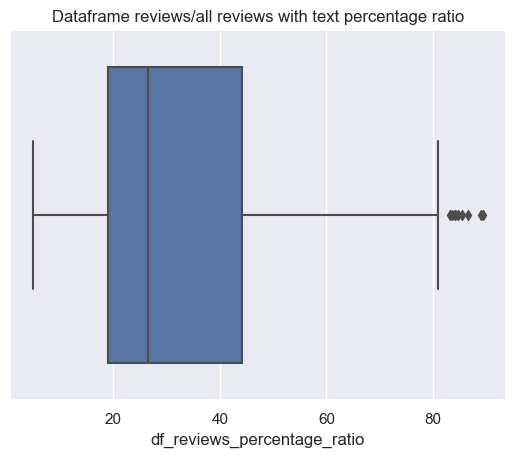

In [55]:
sns.boxplot(x='df_reviews_percentage_ratio',
    data=hotels_number_of_reviews);
plt.title('Dataframe reviews/all reviews with text percentage ratio');

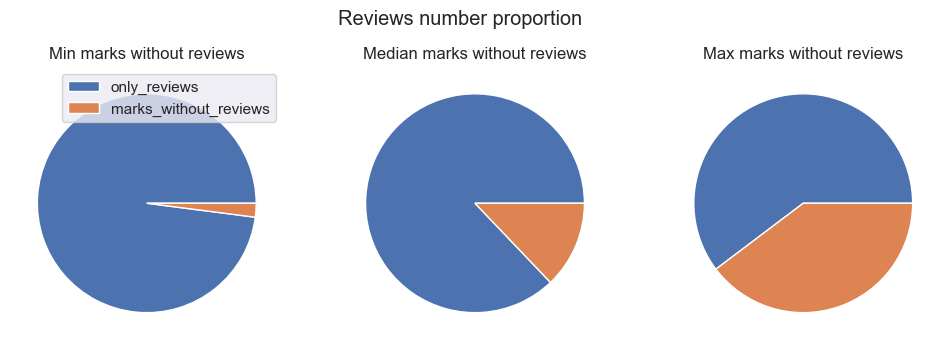

In [56]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
labels = ['only_reviews', 'marks_without_reviews']

pie_data = [hotels_number_of_reviews['only_reviews_percentage_ratio'].max(),
        hotels_number_of_reviews['only_marks_percentage_ratio'].min()]
axes[0].pie(pie_data)
axes[0].set_title('Min marks without reviews');

pie_data = [hotels_number_of_reviews['only_reviews_percentage_ratio'].median(),
        hotels_number_of_reviews['only_marks_percentage_ratio'].median()]
axes[1].pie(pie_data)
axes[1].set_title('Median marks without reviews');

pie_data = [hotels_number_of_reviews['only_reviews_percentage_ratio'].min(),
        hotels_number_of_reviews['only_marks_percentage_ratio'].max()]
axes[2].pie(pie_data)
axes[2].set_title('Max marks without reviews');
axes[0].legend(labels, loc='best');
fig.suptitle('Reviews number proportion');

**Note**:
- Таким образом, выгрузка отзывов не пропорциональна общему количеству отзывов
у всех отелей, об этом говорит наличие разборса в boxplot. 
- Оценки без отзывов составляют малую часть общего количества оценок с отзывами.
Однако, от отеля к отелю это соотношение сильно разнится.
Возможно их соотношение влияет на предсказываемую оценку отеля,
 что дополнительно можно проверить.

**Введём относительное количество оценок без отзывов**

In [57]:
data['relative_additional_number_of_scoring'] =\
    data['additional_number_of_scoring']/data['total_number_of_reviews']

Посмотрим на его распределение

count    515738.000000
mean          0.179050
std           0.075779
min           0.020408
25%           0.109046
50%           0.176425
75%           0.239130
max           0.397059
Name: relative_additional_number_of_scoring, dtype: float64

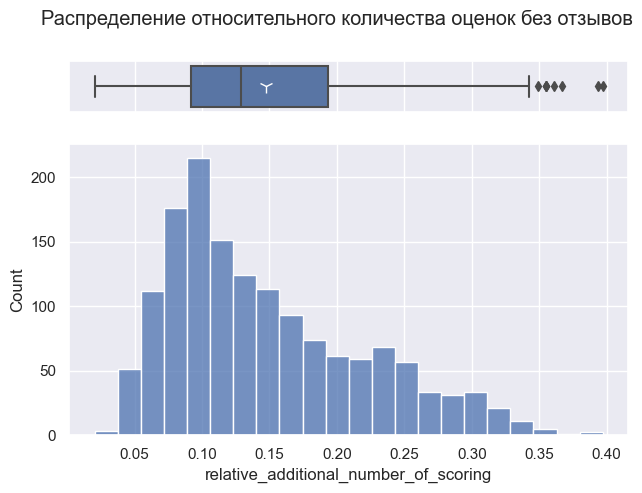

In [58]:
display(data['relative_additional_number_of_scoring'].describe())

rel_add_n_score = data.groupby(by=['hotel_name'])\
    ['relative_additional_number_of_scoring'].median().reset_index()
box_hist_plot(rel_add_n_score, 'relative_additional_number_of_scoring',\
    'Распределение относительного количества оценок без отзывов')

Распределение смещено вправо. Будем считать его ненормальным

Введём категориальный признак, отвечающий за количество оценок без отзывов

In [59]:
data['category_additional_number_of_scoring'] = get_bins_categories(
    data['relative_additional_number_of_scoring'], 10)

Оценим его влияние на рейтинг

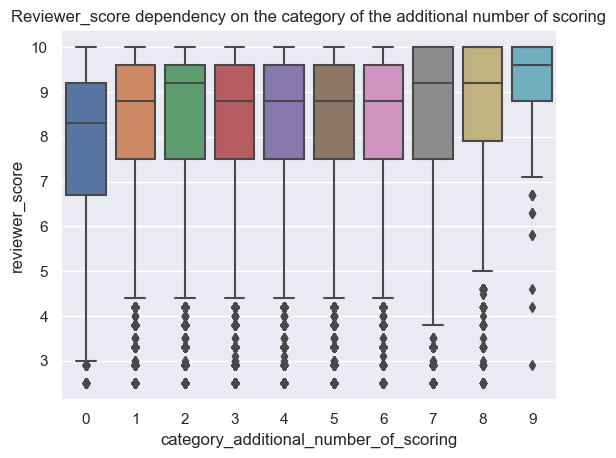

In [60]:
sns.boxplot(x='category_additional_number_of_scoring', y = 'reviewer_score', 
    data=data.query('sample==1'))
plt.title('Reviewer_score dependency on the category of the additional number of scoring');

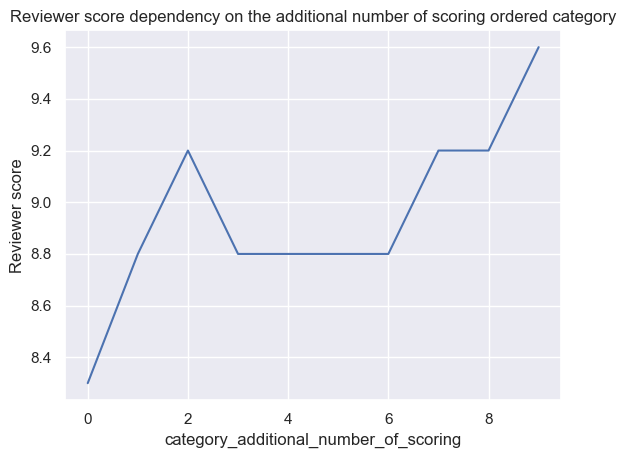

In [61]:
additional_score = data.query('sample==1').groupby(
    by='category_additional_number_of_scoring')\
        ['reviewer_score'].median().reset_index()
# display(additional_score)
additional_score.plot.line(x='category_additional_number_of_scoring', 
    y='reviewer_score', legend=False, ylabel='Reviewer score',
    title='Reviewer score dependency on the additional number of scoring ordered category');

Имеется некоторое положительное неубывающее влияние. Пока оставим переменную

#### **days_since_review** - edited

Количество дней между оставлением отзыва и датой выгрузки. Приведём к числовому формату

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 34 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   hotel_address                                   515738 non-null  object        
 1   additional_number_of_scoring                    515738 non-null  int64         
 2   review_date                                     515738 non-null  datetime64[ns]
 3   average_score                                   515738 non-null  float64       
 4   hotel_name                                      515738 non-null  object        
 5   reviewer_nationality                            515738 non-null  object        
 6   negative_review                                 515738 non-null  object        
 7   review_total_negative_word_counts               515738 non-null  int64         
 8   total_number_of_reviews           

In [63]:
data['days_since_review_int'] = data['days_since_review']\
    .apply(lambda x: int(x.split(' ')[0]))
data['days_since_review_int']

0          13
1         234
2         616
3         656
4         444
         ... 
515733    106
515734    171
515735    543
515736     74
515737    363
Name: days_since_review_int, Length: 515738, dtype: int64

count    515738.000000
mean        354.441932
std         208.928124
min           0.000000
25%         175.000000
50%         353.000000
75%         527.000000
max         730.000000
Name: days_since_review_int, dtype: float64

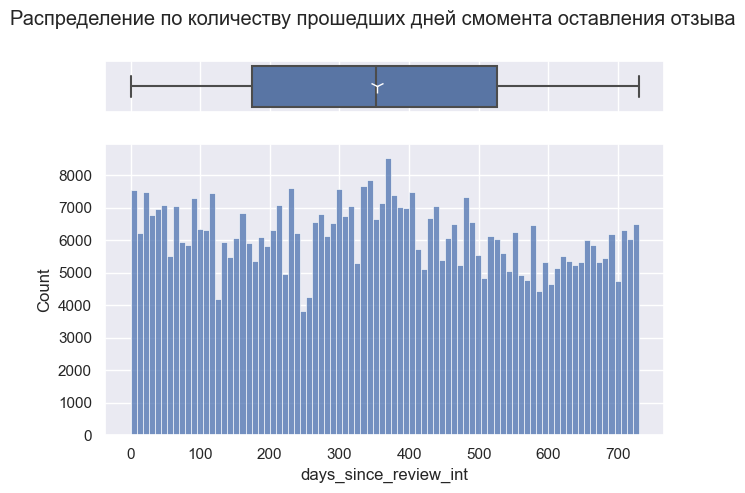

In [64]:
display(data['days_since_review_int'].describe())
box_hist_plot(data=data, x='days_since_review_int',\
    title='Распределение по количеству прошедших дней с'+
    'момента оставления отзыва')

Проверим влияние количества дней с момента отправки отзыва на рейтинг, 
для этого разделим на категории со средней длиной около месяца

In [65]:
data['category_days_since_review'] = get_bins_categories(
    data['days_since_review_int'], 24)

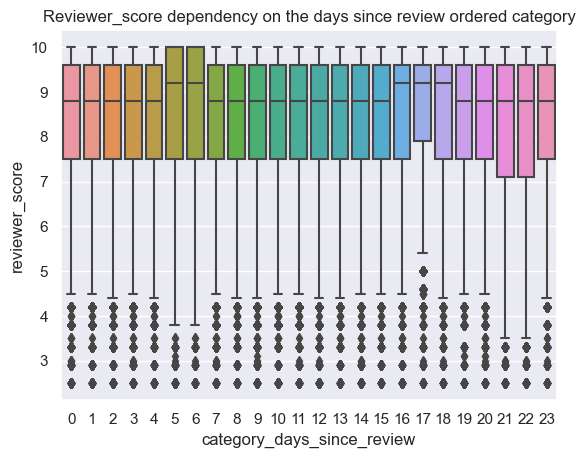

In [66]:
sns.boxplot(x='category_days_since_review', y = 'reviewer_score', 
    data=data.query('sample==1'))
plt.title('Reviewer_score dependency on the days since review ordered category');

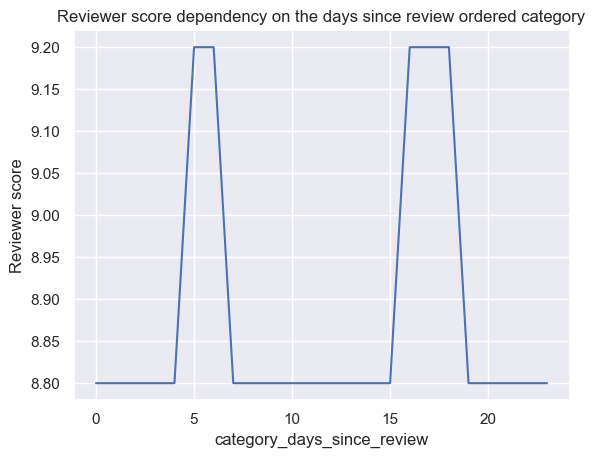

In [67]:
days_score = data.query('sample==1').groupby(
    by='category_days_since_review'
)['reviewer_score'].median().reset_index()
# display(days_score)
days_score.plot.line(x='category_days_since_review', 
    y='reviewer_score', legend=False, ylabel='Reviewer score',
    title='Reviewer score dependency on the days since review ordered category');

**Note:**
- Отзывы примерно равномерно распределены по количеству дней с момента отправки
- Вероятнее всего эти пики связаны с сезонностью, описанной выше. 
В зимнее время рейтинги выставляют выше.

#### **lat** и **lng** -> edited

Эти колонки содержат явные пропуски

In [68]:
lat_nans = data['lat'].isna().sum()/data.shape[0]*100
lng_nans = data['lng'].isna().sum()/data.shape[0]*100
print(f'Доля пропусков широты {round(lat_nans,2)}%, '+\
    f'долготы {round(lng_nans,2)}%')

Доля пропусков широты 0.63%, долготы 0.63%


Рассмотрим, что за отели имеют пропуски

In [69]:
hotels_without_coordinates = data[data['lat'].isna() | data['lng'].isna()]\
    .groupby(by=['hotel_name'])['hotel_name'].count()
display(hotels_without_coordinates)
print('Количество отелей без географических координат:',\
    hotels_without_coordinates.shape[0])

hotel_name
Austria Trend Hotel Schloss Wilhelminenberg Wien    194
City Hotel Deutschmeister                            93
Cordial Theaterhotel Wien                            57
Derag Livinghotel Kaiser Franz Joseph Vienna        147
Fleming s Selection Hotel Wien City                 658
Holiday Inn Paris Montmartre                         55
Hotel Advance                                        28
Hotel Atlanta                                       389
Hotel City Central                                  563
Hotel Daniel Vienna                                 245
Hotel Park Villa                                     61
Hotel Pension Baron am Schottentor                  223
Maison Albar Hotel Paris Op ra Diamond              290
Mercure Paris Gare Montparnasse                      37
NH Collection Barcelona Podium                      146
Renaissance Barcelona Hotel                          33
Roomz Vienna                                         49
Name: hotel_name, dtype: int64

Количество отелей без географических координат: 17


Проверим, может у этих отелей есть координаты, но в других записях?

In [70]:
hotels_without_coordinates_names = list(hotels_without_coordinates.index)
data[data['hotel_name'].isin(hotels_without_coordinates_names) &\
    data['lng'].notna()]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,splitted_tags,log_review_total_negative_word_counts,log_review_total_positive_word_counts,log_total_number_of_reviews_reviewer_has_given,reviews_count_class,log_total_number_of_reviews,relative_additional_number_of_scoring,category_additional_number_of_scoring,days_since_review_int,category_days_since_review


Таких записей не обранружено

**Note:**
- 17 из 1493 отелей не имеют географических координат
- Имеющийся набор данных можно расширить координатами центров городов и соотнести с городами, извлекаемыми из адреса
- Исходя из координат центра города, а также широты и долготы расположения отеля, можно извлечь расстояние от отеля до центра города
- Пропуски в координатах отелей можно заполнить медианным значением расстояния от центра до отеля

**Дополним данные координатами центров городов**

In [71]:
data['hotel_city'].unique()

array(['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
      dtype=object)

In [72]:
import requests
token = config('YA_TOKEN',default='')
url = 'https://geocode-maps.yandex.ru/1.x'

# Prepare temp column for getting cities and countries
data['city_country'] = data['hotel_city'] + ', '\
    + data['hotel_country']
cities = data['city_country'].unique()

# List of cities locations
cities_loc = []

for city in cities:
    # Get response from yandex
    params = {
        'geocode': city,
        'apikey': token,
        'format': 'json',
        'lang': 'en_US'
    }
    response = requests.get(url, params=params)
    out = response.json()

    # Retrieve location data
    # and object coordinates
    geo_object = out['response']['GeoObjectCollection']\
        ['featureMember'][0]['GeoObject']
    coordinates = geo_object['Point']['pos'].split()
    city_loc = {
        'hotel_city': geo_object['name'],
        'hotel_country': geo_object['metaDataProperty']['GeocoderMetaData']\
            ['AddressDetails']['Country']['CountryName'],
        'center_lng': float(coordinates[0]),
        'center_lat': float(coordinates[1])
        }
    cities_loc.append(city_loc)

# Create df for further merging
cities_loc_df = pd.DataFrame(cities_loc)
display(cities_loc_df)

# Объединим датафреймы
# ПРОВЕРИТЬ!!!
# data = data.merge(cities_loc_df.drop('hotel_country', axis=1), 
# on='hotel_city', how='left')

data = data.merge(cities_loc_df, 
on=['hotel_city', 'hotel_country'], how='left')
data.info()

,hotel_city,hotel_country,center_lng,center_lat
0,Milan,Italy,9.189595,45.464183
1,Amsterdam,Netherlands,4.892557,52.373057
2,Barcelona,Spain,2.144449,41.392696
3,London,United Kingdom,-0.127696,51.507351
4,Paris,France,2.351556,48.856663
5,Vienna,Austria,16.363460,48.206487


<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 39 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   hotel_address                                   515738 non-null  object        
 1   additional_number_of_scoring                    515738 non-null  int64         
 2   review_date                                     515738 non-null  datetime64[ns]
 3   average_score                                   515738 non-null  float64       
 4   hotel_name                                      515738 non-null  object        
 5   reviewer_nationality                            515738 non-null  object        
 6   negative_review                                 515738 non-null  object        
 7   review_total_negative_word_counts               515738 non-null  int64         
 8   total_number_of_reviews           

**Извлечём расстояния от отелей до центров соответствующих городов**

Для этого применим формулу гаверсинусов

$$\Delta l = 2r\cdot arcsin(\sqrt{hav(\phi_2 - \phi_1) + cos(\phi_1)cos(\phi_2)hav(\lambda_2 - \lambda_1)})$$

где $hav(\theta) = sin^2(\theta/2)$; $\phi_1$, $\phi_2$ - широты точек; 
$\lambda_1$, $\lambda_2$ - долготы точек в радианах

Проверим корректность формулы

In [73]:
# Проверка валидности по расстоянию между Лондоном и Парижем
london_paris = hav_distance(51.507351, -0.127696, 48.856663, 2.351556)
print(f'Лондон-Париж: {london_paris} km')

Лондон-Париж: 343.5180236172188 km


Считает с точностью до километра.
Погрешность вызвана осреднением радиуса Земли.

Вычислим расстояния от центров соответствующих городов до отелей

In [74]:
data['center_distance'] = data.apply(lambda row:\
    hav_distance(row['center_lat'], row['center_lng'],\
        row['lat'], row['lng']), axis=1)

data['center_distance'].describe()

count    512470.000000
mean          3.238442
std           2.527476
min           0.072794
25%           1.506401
50%           2.594047
75%           4.091961
max          17.145189
Name: center_distance, dtype: float64

Медианное расстояние от центра города до гостиницы - 2.59 км. 
Заполним пропуски этим расстоянием

In [75]:
data['center_distance'] =\
    data['center_distance'].fillna(data['center_distance'].median())
data['center_distance'].describe()

count    515738.000000
mean          3.234359
std           2.519975
min           0.072794
25%           1.511574
50%           2.594047
75%           4.082277
max          17.145189
Name: center_distance, dtype: float64

Оценим распределение

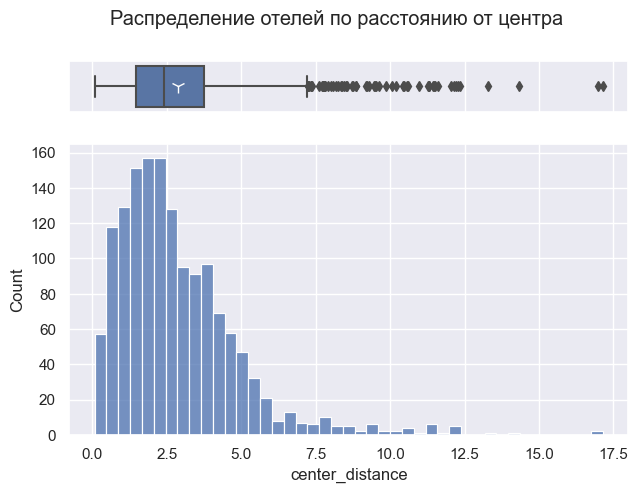

In [76]:
center_distance = data.groupby(by=['hotel_name'])\
    ['center_distance'].median().reset_index()
box_hist_plot(center_distance, 'center_distance',\
    'Распределение отелей по расстоянию от центра')

Распределение похоже на логнормальное. Проверим

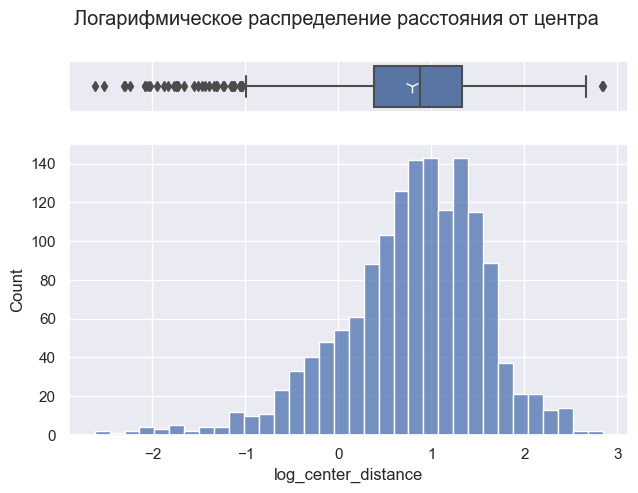

In [77]:
new_column_name = 'log_center_distance'
data[new_column_name] =\
    np.log(data['center_distance'])

log_center_distance = data.groupby(by=['hotel_name'])\
    [new_column_name].median().reset_index()
box_hist_plot(log_center_distance,
    new_column_name,
    'Логарифмическое распределение расстояния от центра')

Проверим на нормальность ниже

**Note:** 
Что касается заполнения пропусков координат, то в дальнейшем можно было бы 
учесть почтовые индексы.

Заполним пропуски lat, lng координатами центров соответствующих городов

Заполнение пропусков данными городов ведёт к пропускам в submission...

In [78]:
data['lat'] = data['lat'].fillna(data['center_lat'])
data['lng'] = data['lng'].fillna(data['center_lng'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 41 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   hotel_address                                   515738 non-null  object        
 1   additional_number_of_scoring                    515738 non-null  int64         
 2   review_date                                     515738 non-null  datetime64[ns]
 3   average_score                                   515738 non-null  float64       
 4   hotel_name                                      515738 non-null  object        
 5   reviewer_nationality                            515738 non-null  object        
 6   negative_review                                 515738 non-null  object        
 7   review_total_negative_word_counts               515738 non-null  int64         
 8   total_number_of_reviews           

### Очистка данных (data cleaning)

Проводится: 
- удаление/разметка дубликатов;
- заполнение пропусков (при необходимости);
- удаление/разметка выбросов и аномалий

#### Дубликаты

Удалим только дубликаты в train_df, так как в submission дубликаты должны остаться нетронутыми. Иначе возникнут проблемы оценки submission

In [79]:
train_df = data.query('sample == 1')
columns_for_duplicates = list(train_df.columns)
columns_for_duplicates.remove('splitted_tags')
dup_count = train_df.duplicated(columns_for_duplicates).sum()
print('Количество дубликатов:', dup_count)
print('Размер всего датафрейма до удаления дубликатов:', data.shape[0])
train_df = train_df.drop_duplicates(columns_for_duplicates)
data = data.query('sample == 0')
data = pd.concat([data, train_df]).reset_index(drop=True)
print('Дубликаты удалены. Размер датафрейма:', data.shape[0])


Количество дубликатов: 307
Размер всего датафрейма до удаления дубликатов: 515738
Дубликаты удалены. Размер датафрейма: 515431


#### Пропуски

- Предварительный анализ данных показал, что явные пропуски содержатся только в **lat** и **lng** - они исключены в новом столбце расстояния от центра города
- Неявные пропуски имеются в **positive_review** и **negative_review**

Проверим отсутствие пропусков

In [80]:
if not data.isna().any().any():
    print('Пропусков нет')
else:
    print('ИМЕЮТСЯ ПРОПУСКИ!')

Пропусков нет


#### Выбросы и аномалии

- Необходимо сделать разные имена для Отеля Регина из разных стран - выполнено

- Можно отметить выбросы в колонке additional_number_of_scoring, или же перейти к относительному количеству оценок без отзывов - последнее и было выполнено

- Выбросы в остальных колонках убираются засчёт введения категориального признака или логарифмирования

## 3. Разведывательный анализ данных (EDA)

Как правило, включает в себя:
- **Проверку статистических гипотез**.
Цель - сформировать корректное с точки зрения статистики представление о виде
неизвестного распределения генеральной совокупности,
о параметрах известных распределений или о статистической значимости разницы 
этих параметров при различных значениях независимой переменной;
- **Проектирование признаков (feature engineering)**:
    - *Создание новых признаков (feature generating)*. 
    Цель - создать более сильные признаки как из существующих данных, 
    так и из внешних источников; путём комбинации нескольких и т.д.
    - *Преобразование признаков (feature transformation)*.
    Цель - подготовить признаки для обучения и 
    повысить качество разрабатываемой модели:
        - Масштабирование, логарифмирование числовых признаков 
        (метод зависит от вида распределения [см. предыдущий пункт]);
        - Уменьшение числа уникальных значений;
        - Кодирование признаков (Ordered-, OneHot-, Binary- encoding).
        Для преобразования категориальные данные в формат, 
        пригодный для обучения - числовой;
- **Отбор признаков (feature selection)**. 
Цель - решение проблемы "проклятия размерности" и повышение качества 
разрабатываемой модели:
    - *выделить значимые признаки*, которые сильнее всего влияют на целевую 
    функцию (target) (оценка значимости признаков статистическими тестами - 
    feature importances);
    - *исключить мультиколлинеарные признаки*, сильно зависимые между собой;
    - *исключить неинформативные признаки*,
    когда большинство записей уникальны, либо наоборот, имеют одно значение.

### Проверка на нормальность

Проверка на нормальность проводится тестом Д Агостино, так как перед нами выборки с большим количеством наблюдений, чем 1000.

In [81]:
check_norm = {
    'log_additional_number_of_scoring': log_addit_n_scoring
    ['log_additional_number_of_scoring'],
    'average_score': average_score['average_score'],
    'log_review_total_negative_word_counts': 
        log_review_total_negative_word_counts
        ['log_review_total_negative_word_counts'],
    'log_review_total_positive_word_counts': 
        log_review_total_positive_word_counts
        ['log_review_total_positive_word_counts'],
    'log_total_number_of_reviews_reviewer_has_given': 
        log_total_number_of_reviews_reviewer_has_given
        ['log_total_number_of_reviews_reviewer_has_given'],
    'log_total_number_of_reviews': log_total_number_of_reviews
    ['log_total_number_of_reviews'],
    'log_center_distance': log_center_distance['log_center_distance']
}

In [82]:
from scipy.stats import normaltest

# Введём уровень значимости
alpha = .01

for elem in check_norm:
    _, p = normaltest(check_norm[elem])
    print(elem)
    print("p = {:g}".format(p))

    if p < alpha:
        print('Отвергаем гипотезу H0 -> Данные НЕнормально распределены')
    else:
        print('Нельзя отвергнуть гипотезу H0 -> Данные распределены нормально')

log_additional_number_of_scoring
p = 0.262926
Нельзя отвергнуть гипотезу H0 -> Данные распределены нормально
average_score
p = 1.60829e-20
Отвергаем гипотезу H0 -> Данные НЕнормально распределены
log_review_total_negative_word_counts
p = 1.09129e-58
Отвергаем гипотезу H0 -> Данные НЕнормально распределены
log_review_total_positive_word_counts
p = 0.00797503
Отвергаем гипотезу H0 -> Данные НЕнормально распределены
log_total_number_of_reviews_reviewer_has_given
p = 0.00449259
Отвергаем гипотезу H0 -> Данные НЕнормально распределены
log_total_number_of_reviews
p = 0.00118797
Отвергаем гипотезу H0 -> Данные НЕнормально распределены
log_center_distance
p = 4.21041e-37
Отвергаем гипотезу H0 -> Данные НЕнормально распределены


Таким образом, можем полагать, что нормально распределен только логарифм 
количества оценок без отзывов

### Создание новых признаков (feature generating)

Признаки создавались в разделе "2. Предварительный анализ и подготовка данных".

### Преобразование признаков (feature transformation)
Масштабирование числовых, кодирование категориальных признаков и т.д.

**Масштабирование числовых признаков**

Можно было бы применить *стандартизацию* для log_additional_number_of_scoring,
для остальных *нормализацию*: 
- *RobustScaler* для большинства признаков (имеющих выбросы), 
- *MinMaxScaler* был бы применим при отсутсвии выбросов.

Но так как для большинства применяется RobustScaler, применим его везде.

In [83]:
# Инициализируем стандартизатор
#s_scaler = preprocessing.StandardScaler()
# Инициализируем нормализаторы
# Min-Max Scaler
#mm_scaler = preprocessing.MinMaxScaler()

# RobustScaler
r_scaler = preprocessing.RobustScaler()

# Проведём стандартизацию
# s_cols = ['log_additional_number_of_scoring']
# data[s_cols] =\
#     s_scaler.fit_transform(data[s_cols]\
#         .values.reshape(-1, 1))

# Проведём нормализацию для остальных колонок
# r_cols = [
#     'additional_number_of_scoring',
#     'review_total_negative_word_counts', 'review_total_positive_word_counts',
#     'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews',
#     'center_distance'
#     ]
# mm_cols = [
#     'average_score', 
#     'log_review_total_negative_word_counts', 
#     'log_review_total_positive_word_counts', 
#     'log_total_number_of_reviews_reviewer_has_given', 
#     'log_total_number_of_reviews', 'relative_additional_number_of_scoring', 
#     'days_since_review_int', 'lat', 'lng', 'center_lng', 'center_lat', 
#     'log_center_distance'
#     ]

r_cols = [
    'log_additional_number_of_scoring', 'additional_number_of_scoring',
    'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews',
    'center_distance', 'average_score', 
    'log_review_total_negative_word_counts', 
    'log_review_total_positive_word_counts', 
    'log_total_number_of_reviews_reviewer_has_given', 
    'log_total_number_of_reviews', 'relative_additional_number_of_scoring', 
    'days_since_review_int', 'lat', 'lng', 'center_lng', 'center_lat', 
    'log_center_distance'
]

# data[mm_cols] = r_scaler.fit_transform(data[mm_cols])

data[r_cols] = r_scaler.fit_transform(data[r_cols])

data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score,...,log_review_total_positive_word_counts,log_total_number_of_reviews_reviewer_has_given,reviews_count_class,log_total_number_of_reviews,relative_additional_number_of_scoring,days_since_review_int,center_lng,center_lat,center_distance,log_center_distance
count,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.00000,515431.000000,...,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000
mean,0.318279,-0.003386,0.454274,0.246869,0.398667,0.595031,-0.625885,0.576567,0.74985,6.296715,...,-0.031224,0.089539,1.057880,-0.065777,0.020487,0.003993,0.603072,-0.629070,0.249183,-0.087051
std,1.019591,0.782905,1.413856,0.937631,1.282541,1.576963,1.047915,0.936671,0.43310,3.902967,...,0.781503,0.541086,0.808867,0.746890,0.582376,0.593509,0.929109,1.048680,0.980508,0.861705
min,-0.694501,-4.571429,-0.428571,-0.845874,-0.647059,-0.285714,-3.079521,-0.078171,0.00000,0.000000,...,-1.849254,-0.528321,0.000000,-3.404720,-1.199028,-1.002841,0.000000,-3.064245,-0.980764,-3.596712
25%,-0.352342,-0.428571,-0.333333,-0.393608,-0.352941,-0.285714,-0.995063,-0.032753,0.00000,0.000000,...,-0.515836,-0.528321,0.000000,-0.533528,-0.517821,-0.505682,0.000000,-1.000000,-0.421080,-0.543599
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,7.900000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.647658,0.571429,0.666667,0.606392,0.647059,0.714286,0.004937,0.967247,1.00000,9.600000,...,0.484164,0.471679,2.000000,0.466472,0.482179,0.494318,1.000000,0.000000,0.578920,0.456401
max,4.765784,2.000000,19.000000,5.880259,22.588235,50.285714,0.272542,3.292052,1.00000,10.000000,...,2.602082,2.295571,2.000000,1.802508,1.695632,1.071023,3.284925,0.262266,5.660374,1.900848


**Кодирование категориальных признаков**
Порядковые категориальные признаки уже закодированы. Остались номинальные

In [84]:
nom_cat_cols = ['hotel_country', 'hotel_city', 'review_season']
data = pd.get_dummies(data, columns=nom_cat_cols)

### Отбор признаков (feature selection)
Для категориальных: 
- Хи-квадрат?
- ANOVA

Для непрерывных: 
- ANOVA?
- Корреляция Спирмена?

Будем использовать данные из датасета train

Выделим порядковые категориальные и числовые признаки

In [85]:
num_cols = r_cols.copy()
# num_cols.extend(s_cols)
print(f'Номинальные признаки, {len(num_cols)}:')
print(num_cols)

set_object_cols = set(data.dtypes[(data.dtypes == 'datetime64[ns]')\
    | (data.dtypes == 'object')].index)

cat_cols = list(set(data.columns) - set(num_cols) - set_object_cols 
    - set([TARGET_NAME, 'sample']))
print(f'Категориальные признаки, {len(cat_cols)}:')
print(cat_cols)

Номинальные признаки, 19:
['log_additional_number_of_scoring', 'additional_number_of_scoring', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews', 'center_distance', 'average_score', 'log_review_total_negative_word_counts', 'log_review_total_positive_word_counts', 'log_total_number_of_reviews_reviewer_has_given', 'log_total_number_of_reviews', 'relative_additional_number_of_scoring', 'days_since_review_int', 'lat', 'lng', 'center_lng', 'center_lat', 'log_center_distance']
Категориальные признаки, 23:
['winter_review', 'hotel_city_Amsterdam', 'hotel_city_Vienna', 'hotel_city_Milan', 'hotel_name_word_count', 'reviews_count_class', 'review_season_summer', 'review_season_spring', 'hotel_country_Spain', 'hotel_city_London', 'review_season_winter', 'hotel_rating', 'hotel_country_Austria', 'review_month', 'hotel_country_Italy', 'hotel_city_Barcelona', 'review_season_autumn', 'category_days_since_rev

Разделим датасет на признаки и целевую функцию

In [86]:
hotels = data.query('sample == 1')
X = hotels.drop(TARGET_NAME, axis=1)
y = hotels[TARGET_NAME]

**Тесты на сравнение выборок**

Сравним числовые признаки

days_since_review_int                                7.372380
center_lat                                          18.701777
lat                                                 18.779521
center_lng                                          22.444839
lng                                                 22.812563
relative_additional_number_of_scoring               32.107026
log_additional_number_of_scoring                    40.295637
center_distance                                     43.008551
additional_number_of_scoring                        49.876258
total_number_of_reviews                             63.454704
total_number_of_reviews_reviewer_has_given          71.470907
log_center_distance                                 74.659979
log_total_number_of_reviews                         77.425911
log_total_number_of_reviews_reviewer_has_given      92.899164
review_total_positive_word_counts                  581.651117
log_review_total_positive_word_counts             1529.935586
average_

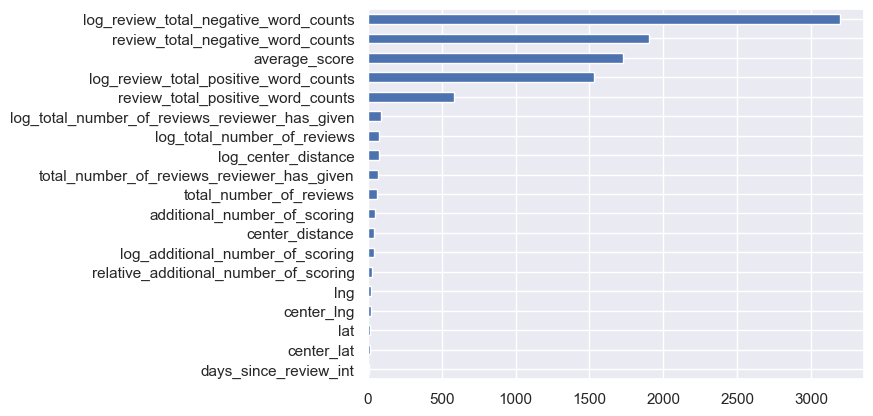

In [87]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
display(imp_num)

Сравним категориальные признаки

review_season_summer                        1.447859
review_season_spring                        2.585926
hotel_name_word_count                       2.733971
hotel_city_Paris                            3.620932
hotel_country_France                        3.620932
hotel_city_Milan                            4.070182
hotel_country_Italy                         4.070182
hotel_country_Netherlands                   5.059085
hotel_city_Amsterdam                        5.059085
category_days_since_review                  7.323460
winter_review                              10.486981
review_season_winter                       11.564226
review_month                               12.740200
hotel_country_Austria                      13.020250
hotel_city_Vienna                          13.020250
review_season_autumn                       14.723355
hotel_city_Barcelona                       14.918107
hotel_country_Spain                        14.918107
category_additional_number_of_scoring      30.

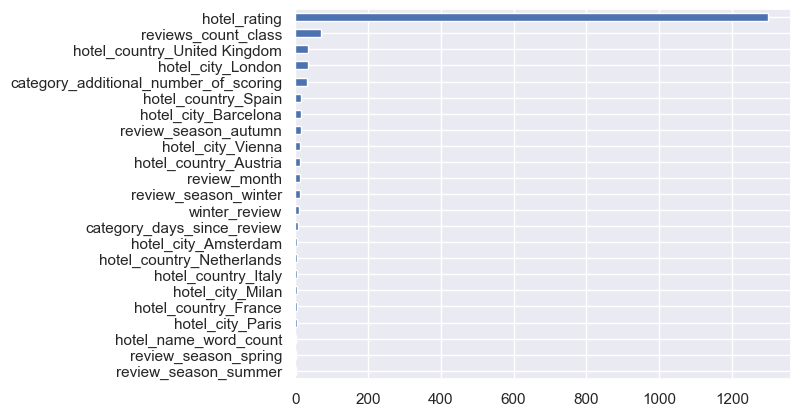

In [88]:
# from sklearn.feature_selection import chi2 # хи-квадрат
# Выдаёт ошибку при его использовании для review_score

# Логичнее тест f_classif, так как таргет - числовой признак
imp_cat = pd.Series(f_classif(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
display(imp_cat)

Пары для эксперимента, что оказывает большее влияние:
- average_score/hotel_rating,
- log_total_number_of_reviews_reviewer_has_given/reviews_count_class,
- category_additional_number_of_scoring/additional_number_of_scoring
/log_additional_number_of_scoring/relative_additional_number_of_scoring,
- 

**Корреляционный анализ. Отбор по мультиколлинеарности**

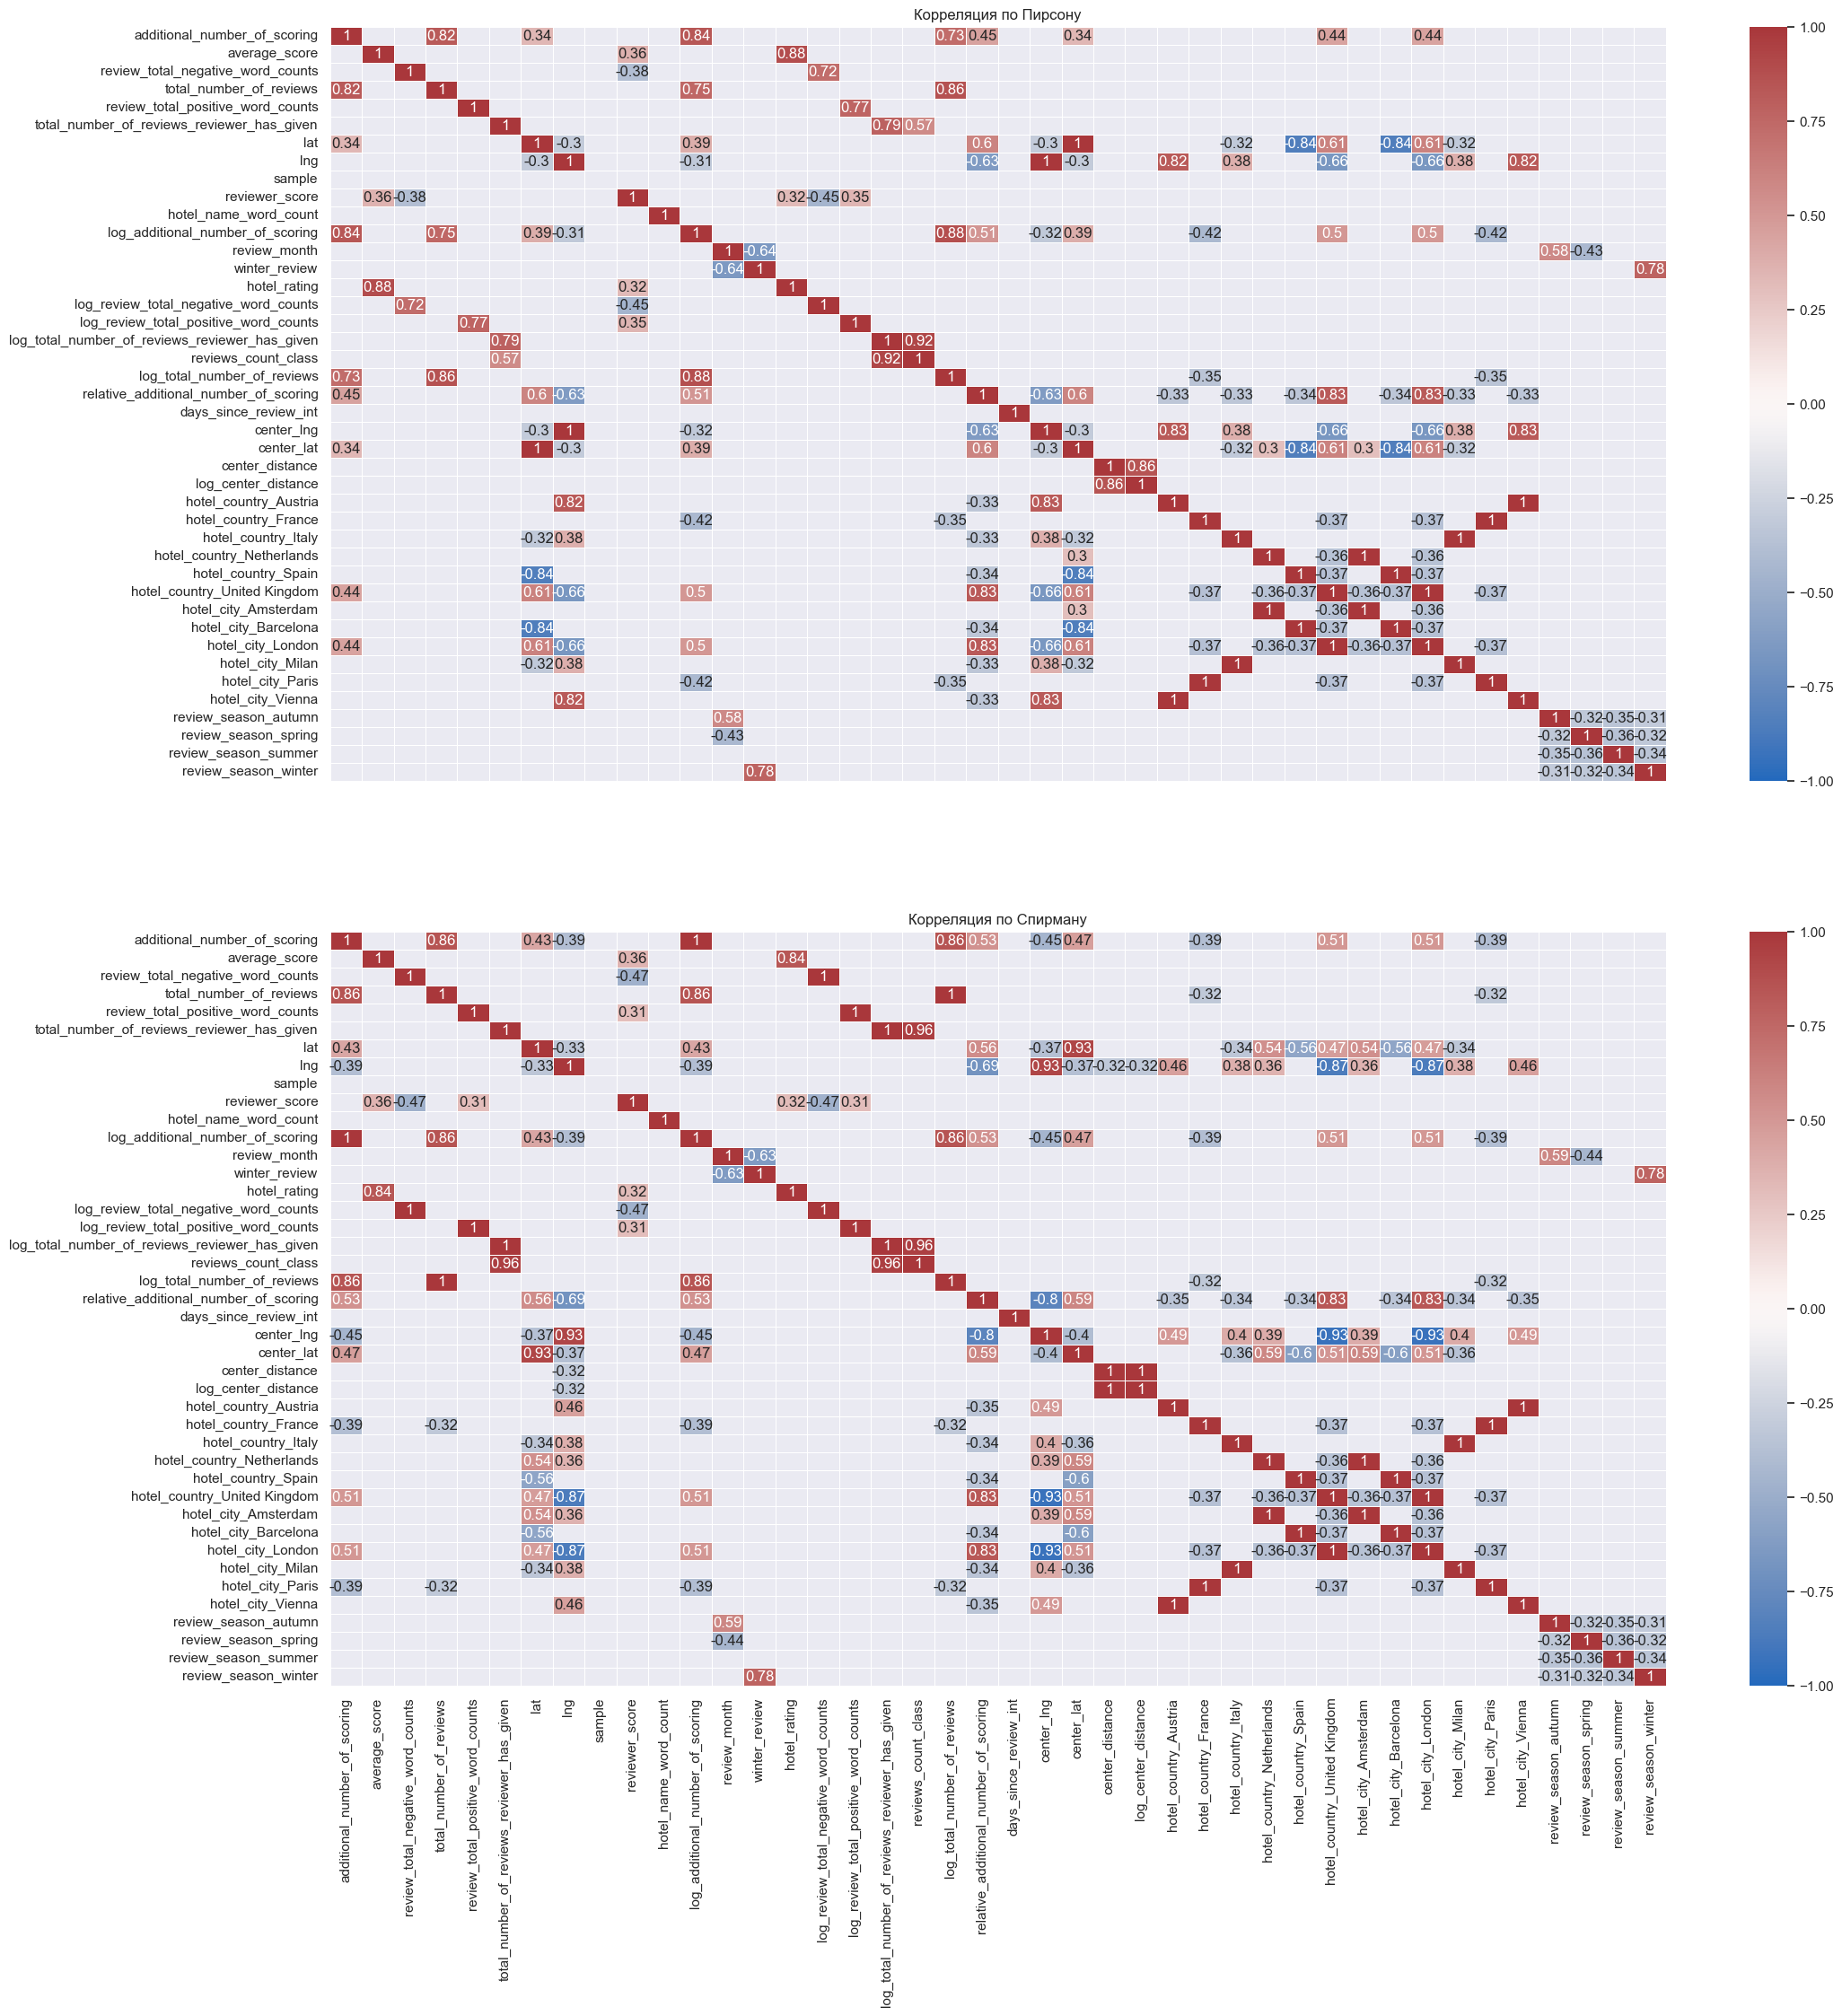

In [89]:
hotels = data.query('sample == 1')
# Убираем предупреждения
import warnings
warnings.filterwarnings("ignore")

pirson_corr = hotels.corr()
spearman_corr = hotels.corr(method='spearman')

# Строим корреляционные графики
fig, (pearson_axes, spearmen_axes) = plt.subplots(2,1, figsize=(24,24));
sns.heatmap(pirson_corr[abs(pirson_corr) >=0.3], vmin=-1, vmax=1, 
            annot=True, ax=pearson_axes, linewidths=.5, cmap="vlag");
sns.heatmap(spearman_corr[abs(spearman_corr) >=0.3], vmin=-1, vmax=1,\
    annot=True, ax=spearmen_axes, linewidths=.5, cmap="vlag");
# Настраиваем графики
pearson_axes.set_title('Корреляция по Пирсону');
pearson_axes.set_xticks([])
spearmen_axes.set_title('Корреляция по Спирману');

**Correlation Notes:**
- Наблюдается сильная скоррелированность 'total_number_of_reviews' и 'additional_number_of_scoring'. При этом связь обоих параметров с 'review_score' почти отсутствует. Убирается скоррелированность при делении 'additional..' на 'total..'. Исходные колонки можно удалить.
- hotel_rating и average_score - надо оставить что-то одно, чтобы исключить мультиколлинеарность.
- Reviews_count_class и Total_number_of_reviews_reviewer_has_hiven - нужно также оставить что-то одно.
- Review_month и winter_review - оставить одно
- Lat/Lng и center_lat/center_lng - оставить одно
- Возможно, для 'total_positive_words_count' и 'total_negative_words_count' имеет смысл ввести соотношение количества слов позитивного/негативного отзывов. Как тогда быть с делением на ноль?..
- Наблюдается прямая связь количества слов в положительном отзыве к выставленной оценке и обратная связь количества слов в отрицательном отзыве к выставленной оценке
- Средняя оценка отеля и оценка в отзыве также скоррелированы
- Неожиданно наблюдать корреляцию широты (прямая) и долготы (обратная) расположения отеля и количества оценок без отзывов. Имеет смысл проанализировать детальнее эту взаимосвязь.

Итого, с точки зрения корреляции Спирмена c целевой функцией (reviewer_score) важны average_score/hotel_rating, и review_total_negative/total_positive_words_count

In [90]:
# baseline_cols = ['additional_number_of_scoring', 'average_score', 
#                  'review_total_negative_word_counts', 'total_number_of_reviews',
#                  'review_total_positive_word_counts',
#                  'total_number_of_reviews_reviewer_has_given',
#                  'lat', 'lng', TARGET_NAME, 'sample']

# # BASELINE
# data = data[baseline_cols]

#### Удалим лишние колонки

In [91]:
drop_cols = ['review_season_summer', 'review_season_spring',
    'hotel_name_word_count', 'winter_review', 'hotel_country_France',
    'hotel_country_Italy', 'hotel_country_Netherlands', 
    'hotel_country_Austria', 'hotel_country_Spain', 
    'hotel_country_United Kingdom',
    'days_since_review_int', 'center_distance',
    'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews',
    'additional_number_of_scoring', 'center_lat', 'center_lng',
    'reviews_count_class']

data = data.drop(drop_cols, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 34 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   hotel_address                                   515431 non-null  object        
 1   review_date                                     515431 non-null  datetime64[ns]
 2   average_score                                   515431 non-null  float64       
 3   hotel_name                                      515431 non-null  object        
 4   reviewer_nationality                            515431 non-null  object        
 5   negative_review                                 515431 non-null  object        
 6   positive_review                                 515431 non-null  object        
 7   tags                                            515431 non-null  object        
 8   days_since_review                 

Проверка мультиколлинеарности. Шаг 2

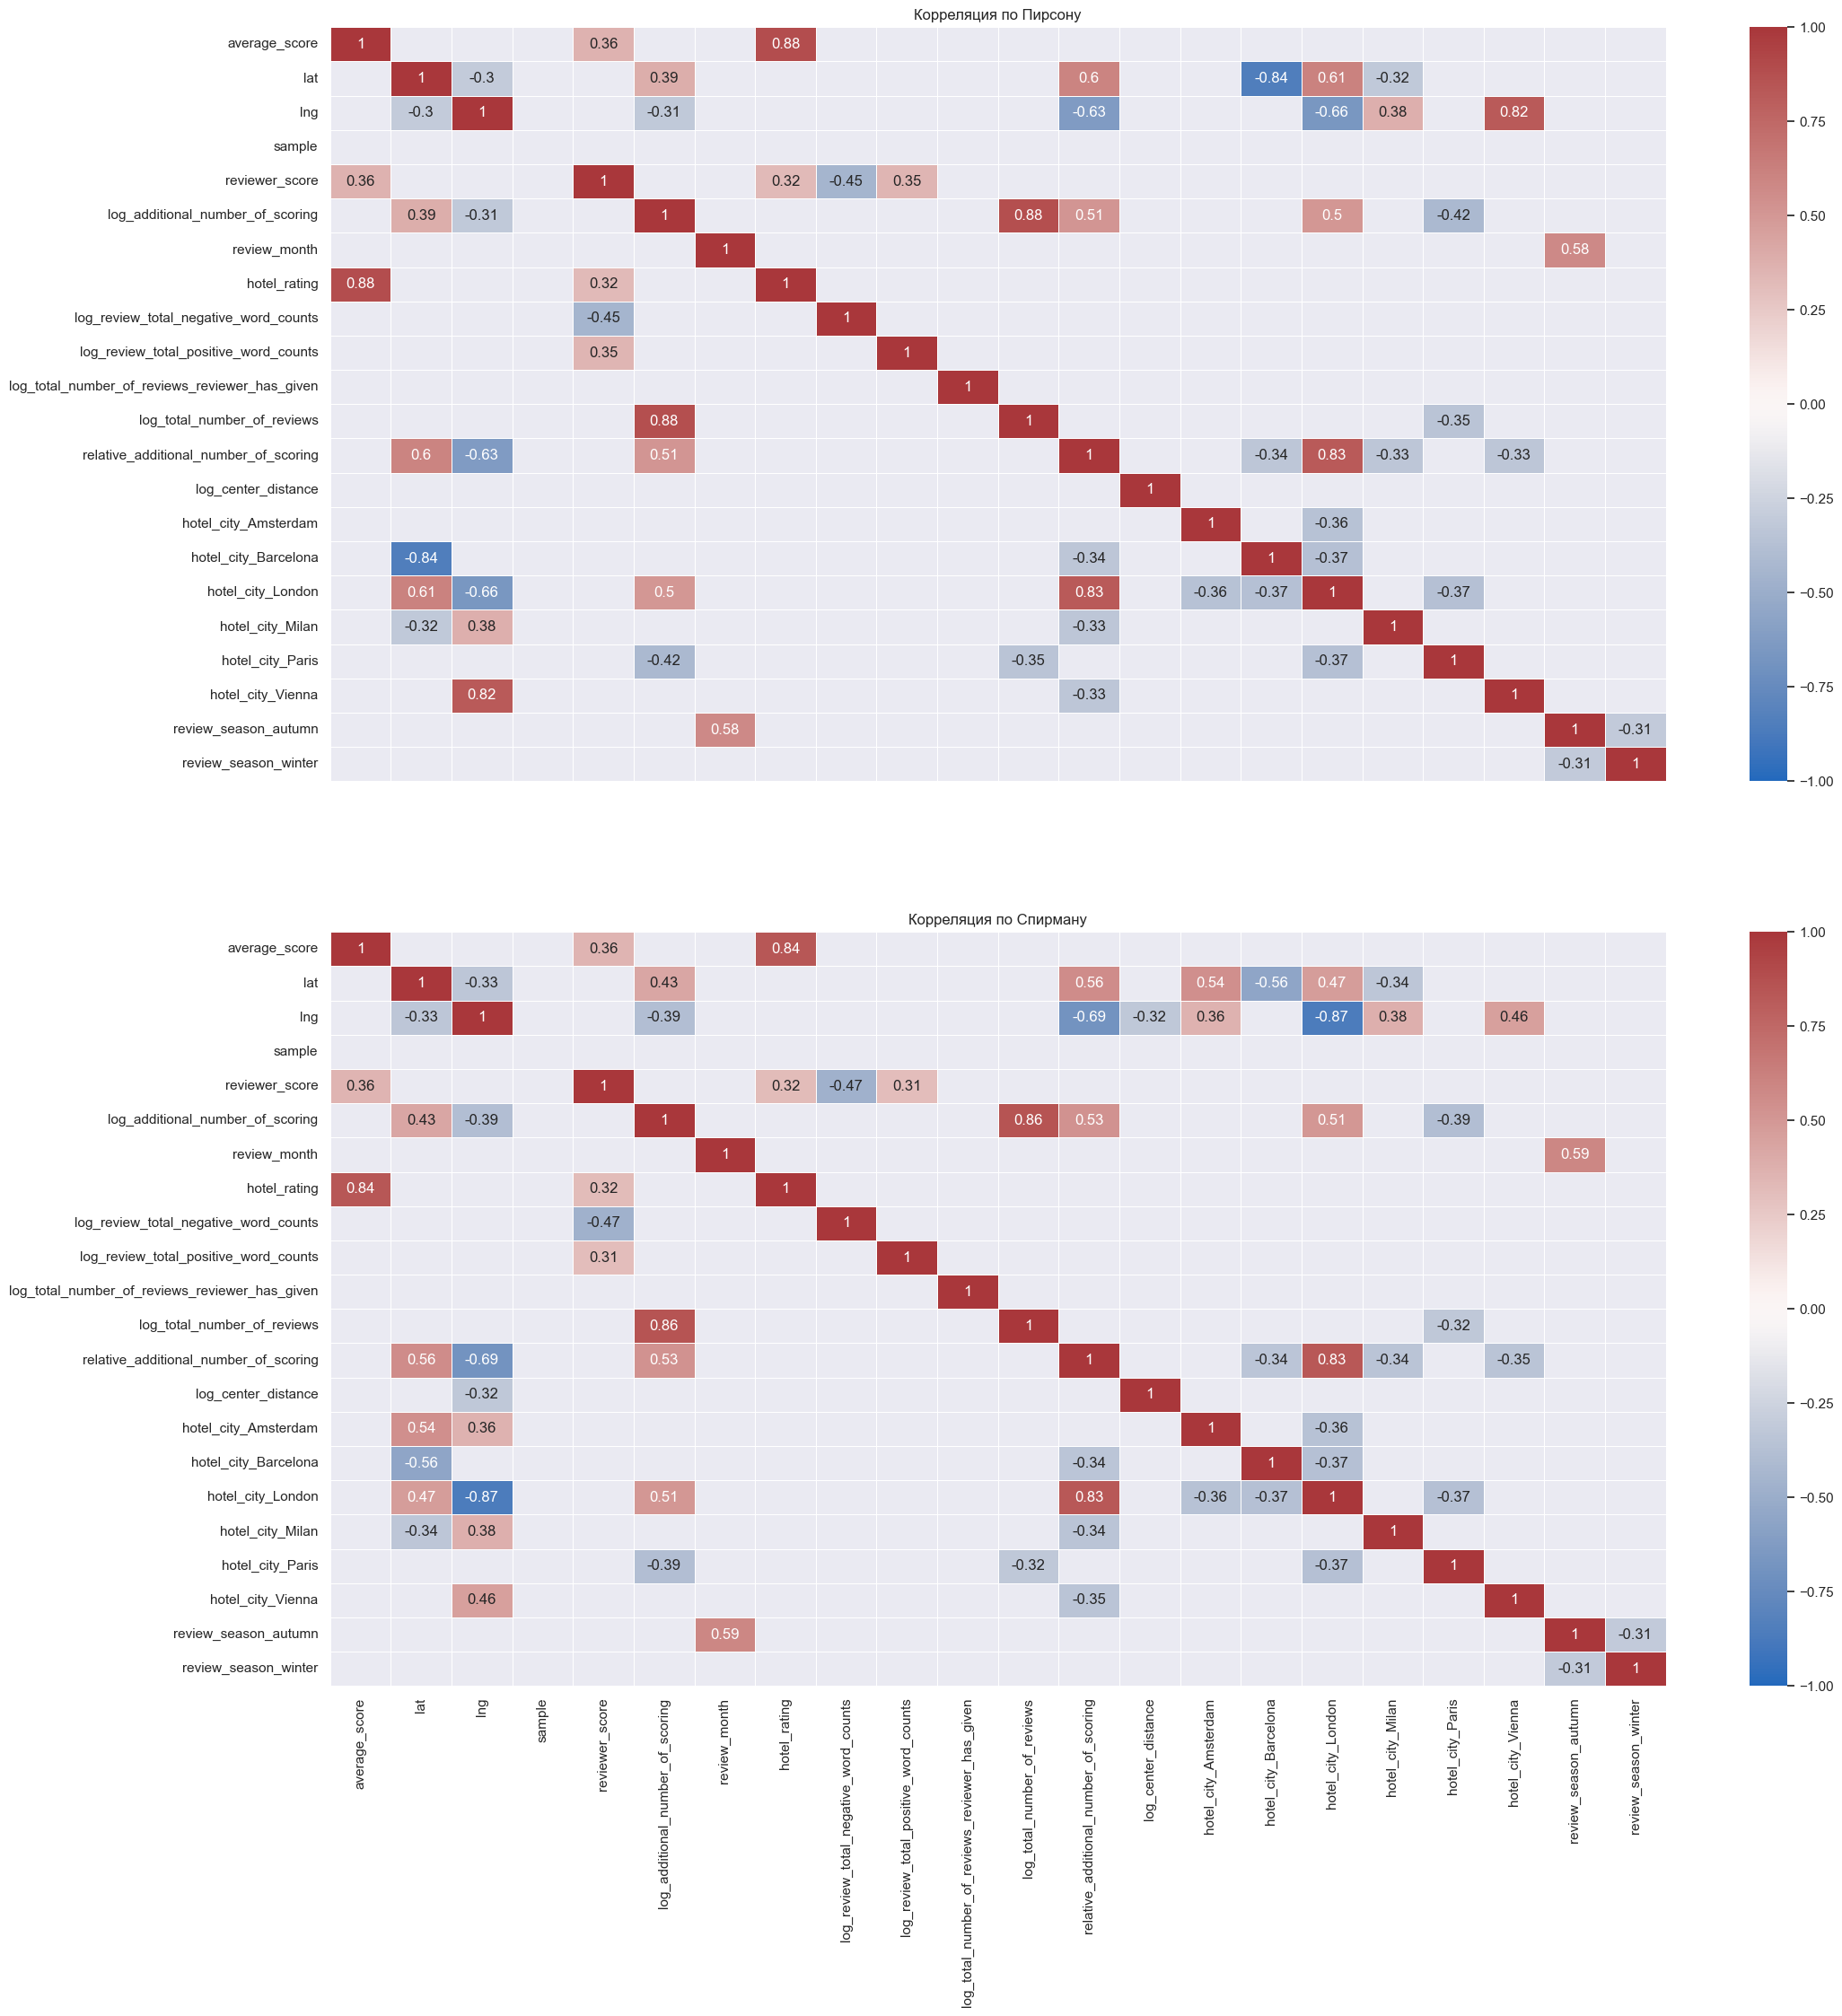

In [92]:
hotels = data.query('sample == 1')
# Убираем предупреждения
import warnings
warnings.filterwarnings("ignore")

pirson_corr = hotels.corr()
spearman_corr = hotels.corr(method='spearman')

# Строим корреляционные графики
fig, (pearson_axes, spearmen_axes) = plt.subplots(2,1, figsize=(24,24));
sns.heatmap(pirson_corr[abs(pirson_corr) >=0.3], vmin=-1, vmax=1, 
            annot=True, ax=pearson_axes, linewidths=.5, cmap="vlag");
sns.heatmap(spearman_corr[abs(spearman_corr) >=0.3], vmin=-1, vmax=1,\
    annot=True, ax=spearmen_axes, linewidths=.5, cmap="vlag");
# Настраиваем графики
pearson_axes.set_title('Корреляция по Пирсону');
pearson_axes.set_xticks([])
spearmen_axes.set_title('Корреляция по Спирману');

**Note:**

Сильные корреляции (Мультиколлинеарность):
- Колонки average_score и hotel_rating, нужно оставить одну, можно
проэкспериментировать. Эксперимент показал, что average_score лучше;
- lat по Пирсону с hotel_city_Barcelona
- lng по Пирсону с hotel_city_Viena
- lng по Спирману с hotel_city_London
- log_additional_number_of_scoring с log_total_number_of_reviews
- relative_additional_number_of_scoring с hotel_city_London

Проведённые эксперименты показали, что:
- average_score лучше
- признаки городов лучше широты и долготы
- вариации additional_number_of_scoring хуже

Колонки удаления второй итерации

In [94]:
# var_drop_cols_best = ['hotel_rating', 'lat', 'lng',
#     'log_additional_number_of_scoring', 
#     'relative_additional_number_of_scoring']
# var_drop_cols_worse = ['hotel_rating', 'hotel_city_London',
#     'hotel_city_Vienna', 'hotel_city_Barcelona',
#     'hotel_city_Amsterdam', 'hotel_city_Milan',
#     'hotel_city_Paris', 'review_season_winter',
#     'review_season_autumn',
#     'log_additional_number_of_scoring']
var_drop_cols = ['hotel_rating', 'lat', 'lng',
    'log_additional_number_of_scoring',
    'relative_additional_number_of_scoring']


data = data.drop(var_drop_cols, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 29 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   hotel_address                                   515431 non-null  object        
 1   review_date                                     515431 non-null  datetime64[ns]
 2   average_score                                   515431 non-null  float64       
 3   hotel_name                                      515431 non-null  object        
 4   reviewer_nationality                            515431 non-null  object        
 5   negative_review                                 515431 non-null  object        
 6   positive_review                                 515431 non-null  object        
 7   tags                                            515431 non-null  object        
 8   days_since_review                 

### Финальная чистка:

In [95]:
# убираем признаки, которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, 
# просто выберем их и удалим
object_columns = [s for s in data.columns if data[s].dtypes in\
    ['object', 'category', 'datetime64[ns]']]
data.drop(object_columns, axis = 1, inplace=True)

# заполняем пропуски самым простым способом
# data = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 17 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   average_score                                   515431 non-null  float64
 1   sample                                          515431 non-null  int64  
 2   reviewer_score                                  515431 non-null  float64
 3   review_month                                    515431 non-null  int64  
 4   log_review_total_negative_word_counts           515431 non-null  float64
 5   log_review_total_positive_word_counts           515431 non-null  float64
 6   log_total_number_of_reviews_reviewer_has_given  515431 non-null  float64
 7   log_total_number_of_reviews                     515431 non-null  float64
 8   log_center_distance                             515431 non-null  float64
 9   hotel_city_Amsterdam      

### Финальная проверка

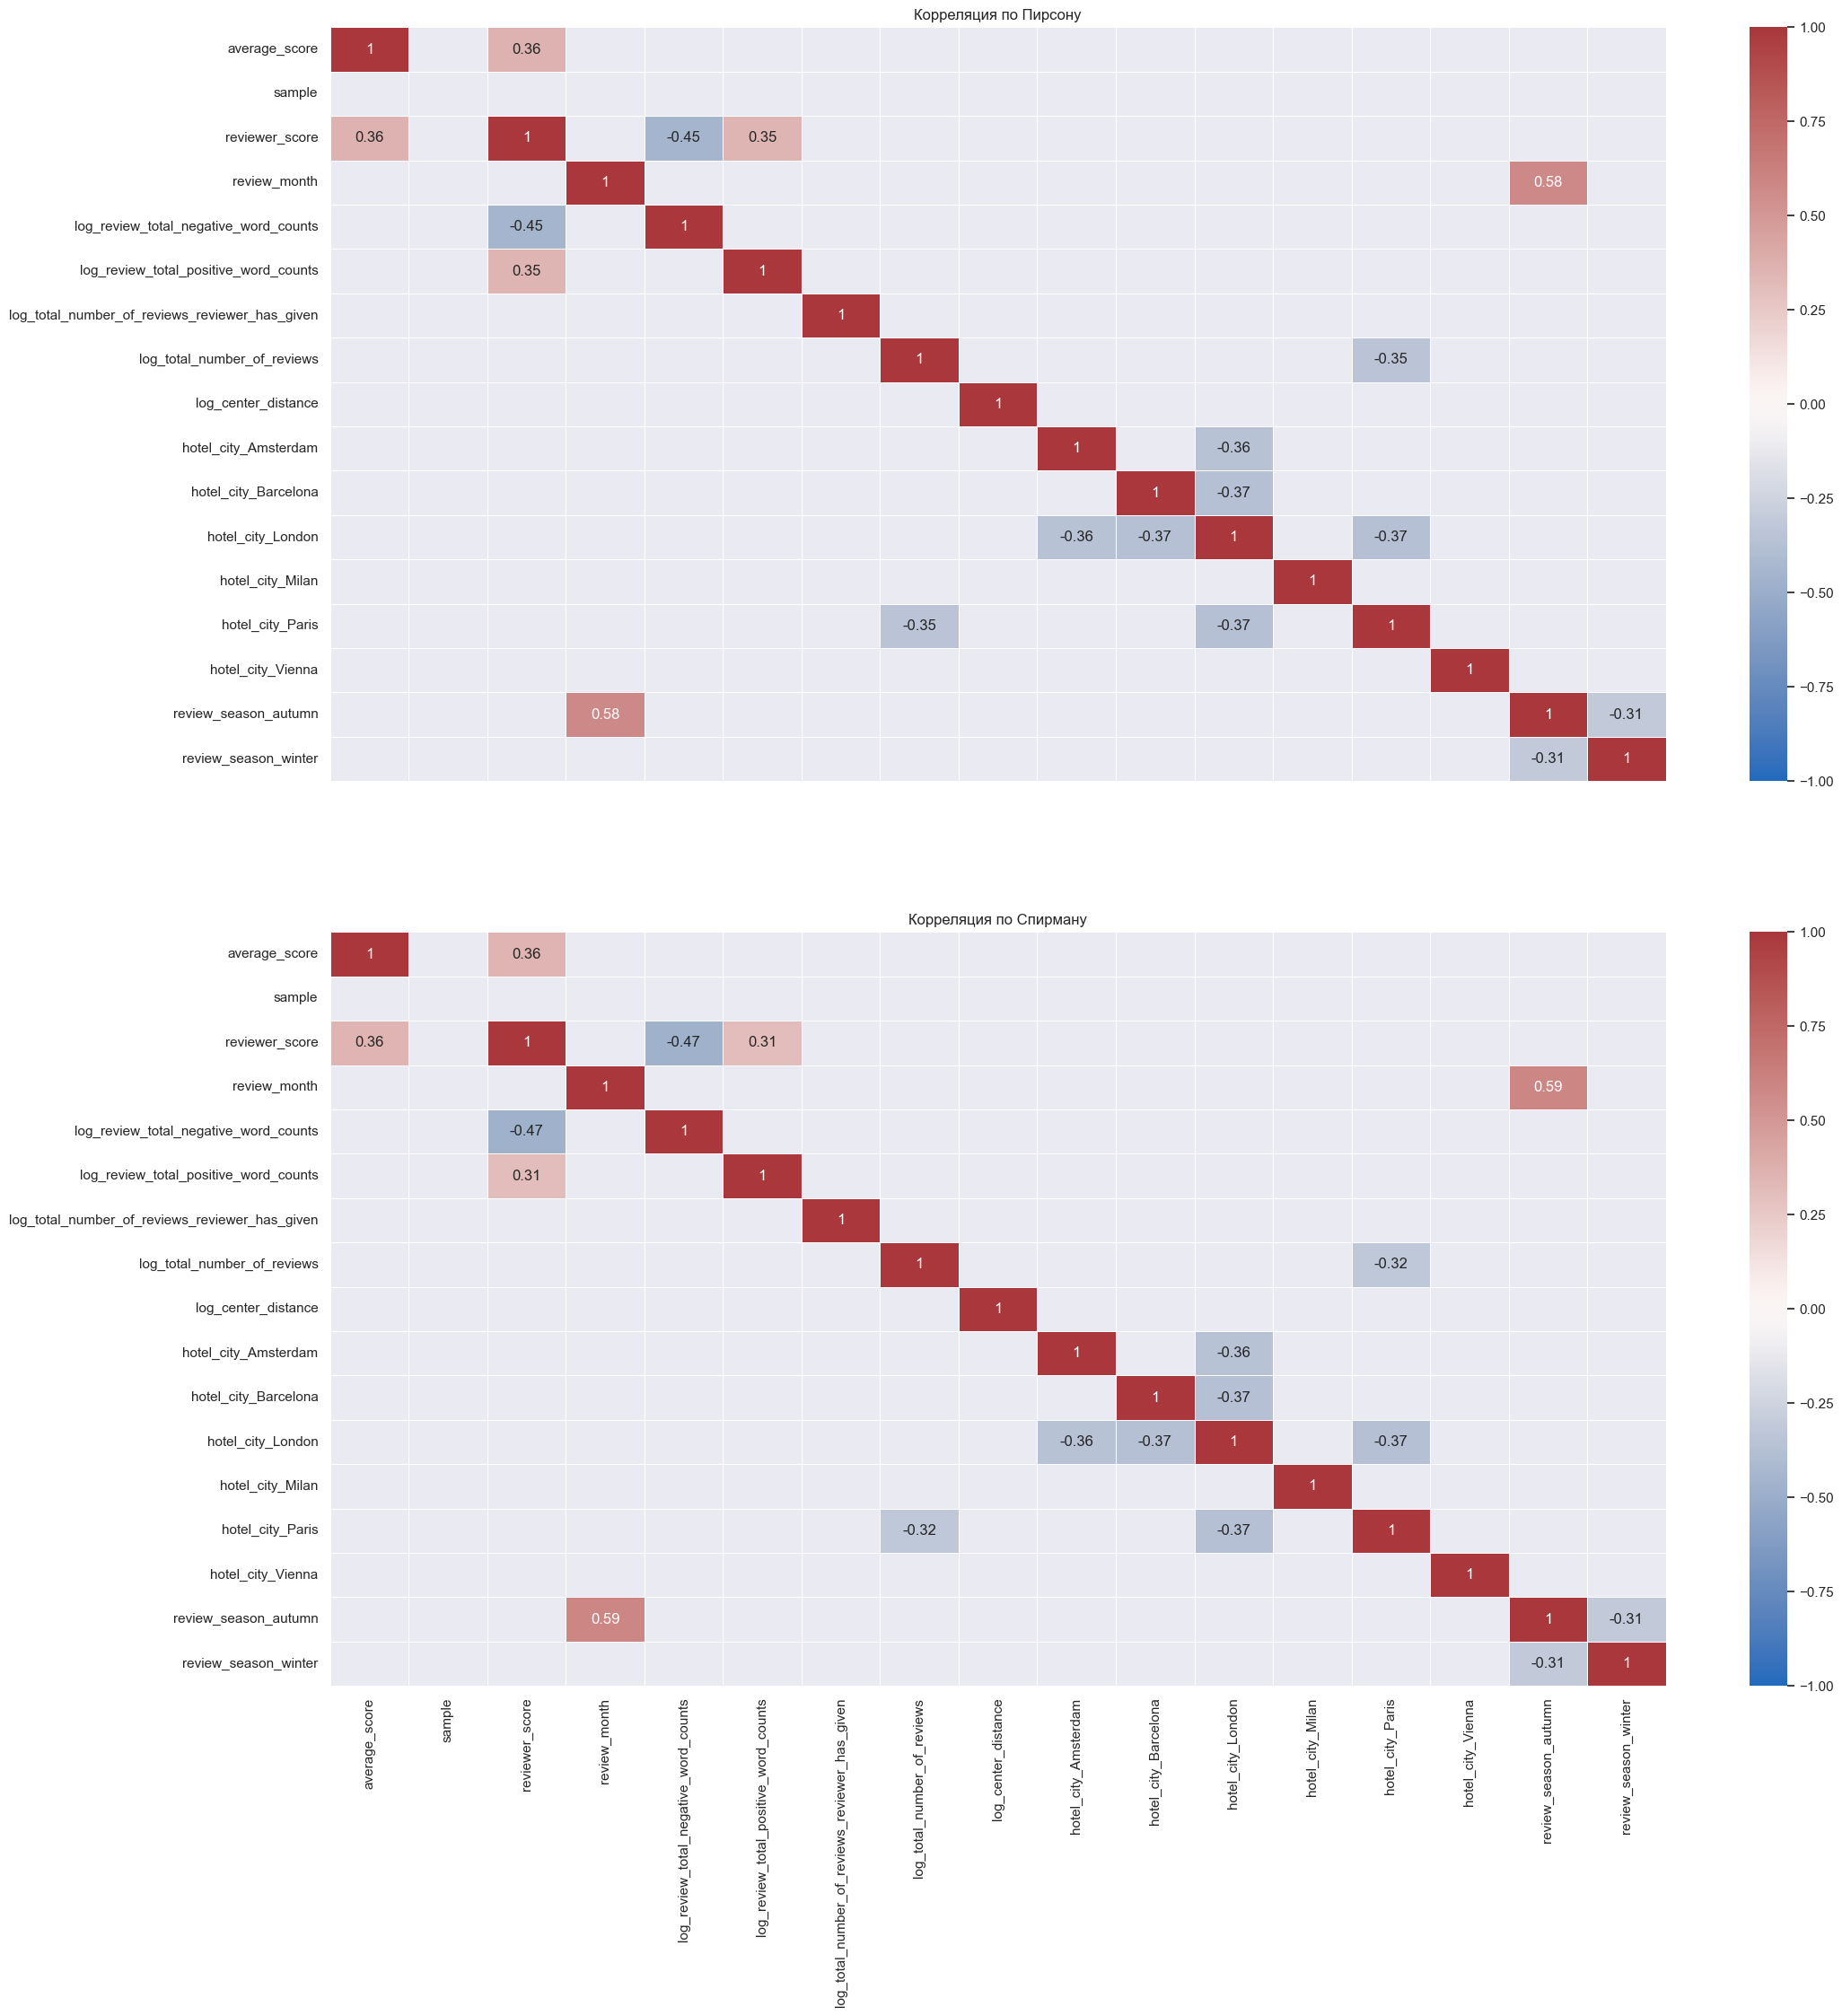

In [96]:
hotels = data.query('sample == 1')
# Убираем предупреждения
import warnings
warnings.filterwarnings("ignore")

pirson_corr = hotels.corr()
spearman_corr = hotels.corr(method='spearman')

# Строим корреляционные графики
fig, (pearson_axes, spearmen_axes) = plt.subplots(2,1, figsize=(24,24));
sns.heatmap(pirson_corr[abs(pirson_corr) >=0.3], vmin=-1, vmax=1, 
            annot=True, ax=pearson_axes, linewidths=.5, cmap="vlag");
sns.heatmap(spearman_corr[abs(spearman_corr) >=0.3], vmin=-1, vmax=1,\
    annot=True, ax=spearmen_axes, linewidths=.5, cmap="vlag");
# Настраиваем графики
pearson_axes.set_title('Корреляция по Пирсону');
pearson_axes.set_xticks([])
spearmen_axes.set_title('Корреляция по Спирману');

## 4. ML-Моделирование

**ОСНОВНЫЕ ЭТАПЫ:**
1. **Разделение набора данных:**
    - Возврат к двум датасетам - **df_train_test** и **df_predict**.
    Датасет **df_train_test** делится далее..
    - "по столбцам":
        - Признаки для обучения модели - **X**
        - Целевая переменная, которую будем предсказывать - **y**
    - "по строкам":
        - Тренировочный набор (**train**), для обучения модели
        - Тестовый набор (**test**), для оценки точности модели
2. **Создание (instant), обучение модели (fit) и предсказание значений (predict)**
Fit на train, predict на test
3. **Оценка качества модели**
    - с помощью метрик проверяется точность прогнозов, сделанных моделью.
4. **Финальное предсказание на df_predict**. С его помощью заполняется **submission.csv**, который и отправляется на проверку на Kaggle.

### 4.1. Разделение набора данных

Вернёмся к двум первоначальным датасетам

In [97]:
# Датасет для обучения и оценки качества
df_train_test = data.query('sample == 1').drop('sample', axis=1)\
    .reset_index(drop=True)
# Датасет для финального предсказания целевой функции, которая не известна
df_predict = data.query('sample == 0').drop('sample', axis=1)

Разбиваем датасет для обучения и оценки качества модели - **df_train_test**

In [98]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)
X = df_train_test.drop([TARGET_NAME], axis=1)
y = df_train_test[TARGET_NAME]

# Наборы данных с меткой "train" будут использоваться для обучения модели, 
# "test" — для тестирования.
# Для тестирования мы будем использовать 25 % от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,\
    random_state=RANDOM_STATE)

### 4.2. Создание и обучение модели

Примечание: 
- для корректной работы все данные в датафрейме, который используется при обучении модели, должны быть в числовых форматах int или float;
- в столбцах не должно быть пропущенных значений. Вместо каждого пропущенного значения вам нужно будет вычислить и поместить в ячейку максимально близкое к реальности значение.

In [99]:
# Создаём модель 
regr = RandomForestRegressor(n_estimators=N_ESTIMATORS)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой 
# выборке.  
# Предсказанные значения записываем в переменную y_pred 
y_pred = regr.predict(X_test)

### 4.3. Оценка качества модели

In [100]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим 
# насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает
# среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
train_mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print('MAPE:', train_mape)
# Запишем показатели метрики
metrics_to_publish = {
    'train_mape': train_mape
}
if 'experiment' in locals():
    experiment.log_metrics(metrics_to_publish)

MAPE: 0.13904086443985114


<AxesSubplot:>

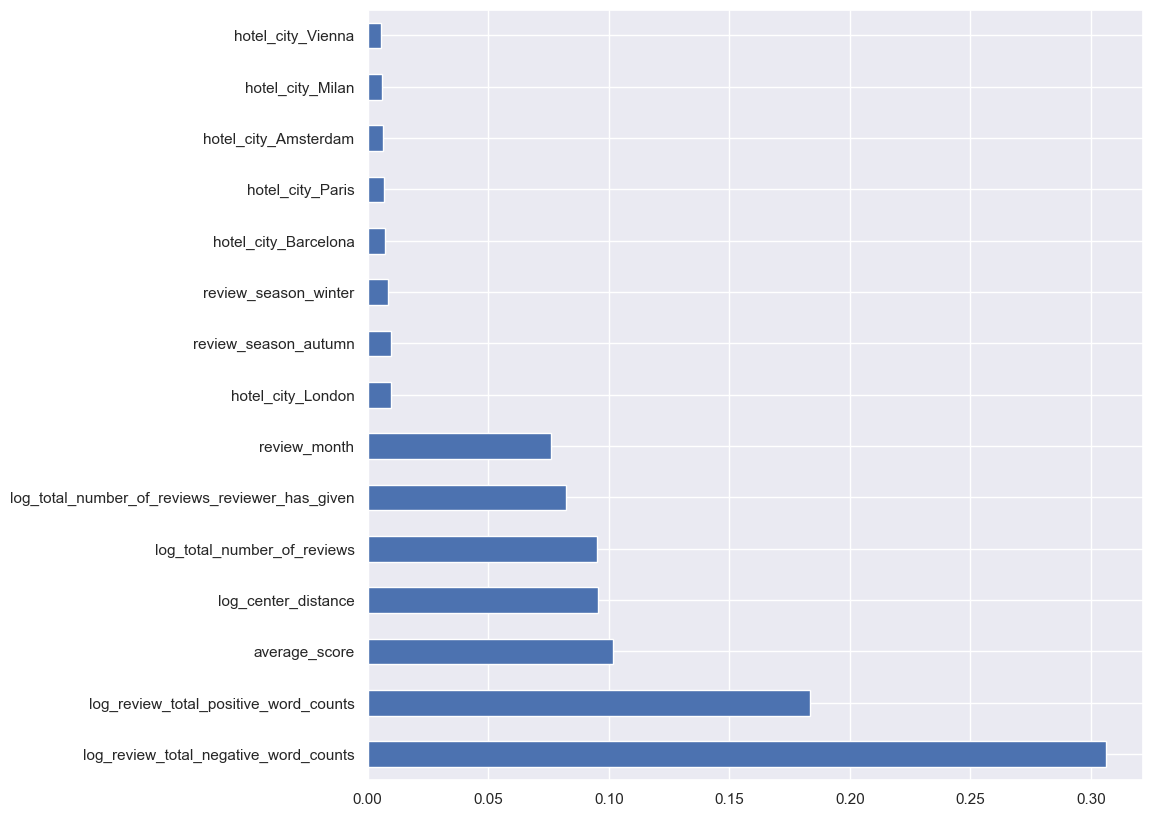

In [101]:
# выведем самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

### Завершение эксперимента

In [102]:
if 'experiment' in locals():
    experiment.end()
    del experiment

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mvulf/booking-reviews/4bf6a314b881445cb555ed29fba11851
COMET INFO:   Metrics:
COMET INFO:     train_mape : 0.13904086443985114
COMET INFO:   Parameters:
COMET INFO:     n_estimators : 100
COMET INFO:     random_state : 42
COMET INFO:     target_name  : reviewer_score
COMET INFO:     test_size    : 0.25
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (10.69 MB)
COMET INFO:     installed packages           : 1
COMET INFO:     notebook  

### Финальное предсказание
С сохранением в файл submission.csv

In [103]:
# Предсказание
df_predict[TARGET_NAME] = regr.predict(df_predict.drop([TARGET_NAME], axis=1))
# Сохранение в датасет для отправки
sample_submission['reviewer_score'] = df_predict[TARGET_NAME]
# Экспорт
sample_submission.to_csv('output/submission.csv', index=False)

### Валидация
В реальных проектах должна проводиться проверка того, что построенная модель 
решает поставленные бизнес задачи; что нет проблем бизнеса, 
которые не были рассмотрены.

На вход поступает уже построенная модель с высокой используемой метрикой, 
полученной на шаге моделирования.

После этого возможно внедрение модели (Model Deployment)

## 5. Заключение